# Logistische Regression: digits

Dieses Jupyter Notebook führt die Ergebnisse des zweiten Projektes im Modul Special Engineering (M30) zum Thema Logistische Regression auf. Als Datenset wird das digits Datenset verwendet.

In [91]:
###############################################################################
# Digits Dataset: Logistische Regression
# Sidney Göhler 544131
#### IKT (M)
# Special Engineering SoSe20
# Prof. Dr. Andreas Zeiser
###############################################################################
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import logistische_regression as lr
import time

from sklearn.datasets import load_digits
from scipy.stats.kde import gaussian_kde

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# erstellt eine Matrix mit den Kennzahlen einer Konfusions Matrix
def confusion_mat(y_true, y_pred):
    tn = np.sum((y_true == y_pred) & (y_true == 0))
    tp = np.sum((y_true == y_pred) & (y_true == 1))
    fp = np.sum((y_true != y_pred) & (y_true == 0))
    fn = np.sum((y_true != y_pred) & (y_true == 1))
    
    return np.array([[tp, fp],[fn, tn]])

In [93]:
#berechent den rmse
def root_means(y_true, y_pred):

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    #mse2 = 1/(len(y_true))*np.sum((y_true - y_pred) ** 2)
    #print(mse,mse2)
    return rmse

In [94]:
#Kreuzvalidierung für eta
def crossval(X, y, eta, k,  tol = 3e-4):
    time_start = time.time()
    
    np.random.seed(0)
    
    train_folds_score = []
    validation_folds_score = []
    
   # print(type(eta))
    #eta = list(np.arange(0.5,0.77,0.05))
    counter_test= []
    rmse_test = []
    J_test = []
    counter_per_eta = []
    rmse_per_eta = []
    J_per_eta = []
    
    #shuffle index once
    m = X.shape[0]
    index = np.arange(m)
    np.random.shuffle(index)
    
    for i,e in enumerate(eta):
        time_start = time.time()
        for fold in range(0, k):
            
            start = int((m/k)*fold)
            end = int((m/k)*(fold+1))

            # X_train aufteilen in train und val
            val = X[index[start:end]]
            val_y = y[index[start:end]]
            
            train = np.concatenate((X[index[:start]], X[index[end:]]))
            train_y = np.concatenate((y[index[:start]], y[index[end:]]))
            #print(e,np.shape(train),np.shape(val))

            theta, J_tr, counter = lr.LogisticRegression_fit(train, train_y, e, tol)

            val_pred = lr.LogisticRegression_predict(val, theta)
            
            counter_test.append(counter)
            rmse = root_means(val_y, val_pred)
            rmse_test.append(rmse)
            J, Jgrad = lr.logistic_cost_function(val, val_y, theta)
            J_test.append(J)
            #print(f'for eta {e} fold {fold} took {counter} iterations in {time.time()-time_start} seconds ({counter/(time.time()-time_start)} iter/sec)\nrmse = {rmse}\nJ = {J}\n')
        
        rmse_m = np.mean(rmse_test)
        J_m = np.mean(J_test)
        counter_m = np.mean(counter_test)
        
        print(f'\n##CV {i}##\nfor eta {e} in {counter_m} iterations'
              + f' took {time.time()-time_start} seconds ({counter/(time.time()-time_start)} iter/sec):'
              + f'\nrmse mean = {rmse_m} | diff: {(rmse_m)-rmse_per_eta[-1] if len(rmse_per_eta)>0 else "0.0"}'
              + f'{" new min!" if len(rmse_per_eta)==0 or rmse_m < np.min(rmse_per_eta) else ""}'
              + f'\nJ mean = {J_m} | diff: {(J_m)-J_per_eta[-1] if len(J_per_eta)>0 else "0.0"}'
              + f'{" new min!" if len(J_per_eta)==0 or J_m < np.min(J_per_eta) else ""}'
              + '\n#########\n')
        
        counter_per_eta.append(counter_m)
        rmse_per_eta.append(rmse_m )
        J_per_eta.append(J_m)
        counter_test= []
        rmse_test = []
        J_test = []

        
    return eta, rmse_per_eta, J_per_eta, counter_per_eta

In [95]:
####################
# load datasets
####################
dataset = load_digits()
#print(dataset.DESCR, '\n', '\n')
X = dataset.data
y = dataset.target

targets = dataset.target_names
images = dataset.images



### Visualisieren von einzelnen Ziffern
Nachdem das Datenset geladen wurde, können vereinzelte Zahlen illustriert werden.

digit = 0 at index = 0


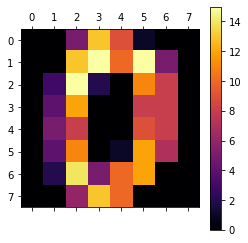

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]



digit = 0 at index = 20


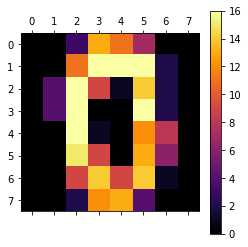

[[ 0.  0.  3. 13. 11.  7.  0.  0.]
 [ 0.  0. 11. 16. 16. 16.  2.  0.]
 [ 0.  4. 16.  9.  1. 14.  2.  0.]
 [ 0.  4. 16.  0.  0. 16.  2.  0.]
 [ 0.  0. 16.  1.  0. 12.  8.  0.]
 [ 0.  0. 15.  9.  0. 13.  6.  0.]
 [ 0.  0.  9. 14.  9. 14.  1.  0.]
 [ 0.  0.  2. 12. 13.  4.  0.  0.]]



digit = 8 at index = 500


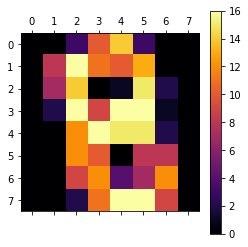

[[ 0.  0.  3. 10. 14.  3.  0.  0.]
 [ 0.  8. 16. 11. 10. 13.  0.  0.]
 [ 0.  7. 14.  0.  1. 15.  2.  0.]
 [ 0.  2. 16.  9. 16. 16.  1.  0.]
 [ 0.  0. 12. 16. 15. 15.  2.  0.]
 [ 0.  0. 12. 10.  0.  8.  8.  0.]
 [ 0.  0.  9. 12.  4.  7. 12.  0.]
 [ 0.  0.  2. 11. 16. 16.  9.  0.]]



digit = 8 at index = 508


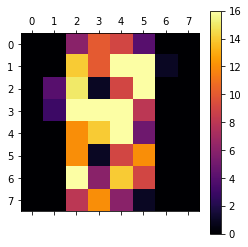

[[ 0.  0.  6. 10.  9.  4.  0.  0.]
 [ 0.  0. 14. 10. 16. 16.  1.  0.]
 [ 0.  4. 15.  1.  9. 16.  0.  0.]
 [ 0.  3. 16. 16. 16.  8.  0.  0.]
 [ 0.  0. 12. 14. 16.  5.  0.  0.]
 [ 0.  0. 12.  1.  9. 12.  0.  0.]
 [ 0.  0. 16.  6. 14.  9.  0.  0.]
 [ 0.  0.  8. 12.  6.  1.  0.  0.]]



digit = 5 at index = 1700


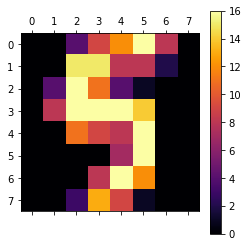

[[ 0.  0.  4.  9. 12. 16.  8.  0.]
 [ 0.  0. 15. 15.  8.  8.  2.  0.]
 [ 0.  4. 16. 11.  4.  1.  0.  0.]
 [ 0.  8. 16. 16. 16. 14.  0.  0.]
 [ 0.  0. 11.  9.  8. 16.  0.  0.]
 [ 0.  0.  0.  0.  7. 16.  0.  0.]
 [ 0.  0.  0.  8. 16. 12.  0.  0.]
 [ 0.  0.  3. 13.  9.  1.  0.  0.]]



digit = 5 at index = 1787


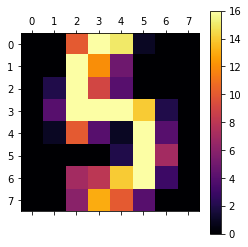

[[ 0.  0. 10. 16. 15.  1.  0.  0.]
 [ 0.  0. 16. 12.  5.  0.  0.  0.]
 [ 0.  2. 16.  9.  4.  0.  0.  0.]
 [ 0.  4. 16. 16. 16. 14.  2.  0.]
 [ 0.  1. 10.  4.  1. 16.  4.  0.]
 [ 0.  0.  0.  0.  2. 16.  7.  0.]
 [ 0.  0.  7.  8. 14. 16.  3.  0.]
 [ 0.  0.  6. 13. 10.  4.  0.  0.]]





In [41]:
for ind in [0,20,500,508,1700,1787]:
    print(f'digit = {y[ind]} at index = {ind}')
    plt.matshow(images[ind], cmap = cm.inferno)
    plt.colorbar()
    plt.show()
    print(f'{images[ind]}\n\n\n')

Zu sehen ist, dass die selben Ziffern häufig minimale Unterschiede untereinander haben. Die Zeilen 3 und 4 wirken stark frequentiert, hingegen die Spalten 0 und 7 sehr schwach.

Anzumerken ist noch, dass die Features des Datensets, aufgrund der Tatsache, dass es sich ausschlißelich um Helligkeitswerte handelt, bereits skaliert sind.
Ein erneutes skalieren ist somit nicht unbedingt Notwendig aber dennoch ratsam, da das Gradientenabstiegsverfahren wohl deutlich schneller Konvergiert.
https://en.wikipedia.org/wiki/Feature_scaling#cite_note-1

In [122]:
mean, std = lr.StandardScaler_fit(X)
print(mean,std)
#X = lr.StandardScaler_transform(X, mean, std+10)
#print(np.max(X),np.min(X))

[0.00000000e+00 3.03839733e-01 5.20478575e+00 1.18358375e+01
 1.18480801e+01 5.78185865e+00 1.36227045e+00 1.29660545e-01
 5.56483027e-03 1.99387869e+00 1.03823038e+01 1.19794101e+01
 1.02793545e+01 8.17584864e+00 1.84641068e+00 1.07957707e-01
 2.78241514e-03 2.60155815e+00 9.90317195e+00 6.99276572e+00
 7.09794101e+00 7.80634391e+00 1.78853645e+00 5.00834725e-02
 1.11296605e-03 2.46967168e+00 9.09126322e+00 8.82136895e+00
 9.92710072e+00 7.55147468e+00 2.31775181e+00 2.22593211e-03
 0.00000000e+00 2.33945465e+00 7.66722315e+00 9.07178631e+00
 1.03016138e+01 8.74401781e+00 2.90929327e+00 0.00000000e+00
 8.90372844e-03 1.58375070e+00 6.88146912e+00 7.22815804e+00
 7.67223150e+00 8.23650529e+00 3.45631608e+00 2.72676683e-02
 7.23427935e-03 7.04507513e-01 7.50695604e+00 9.53923205e+00
 9.41624930e+00 8.75848637e+00 3.72509738e+00 2.06455203e-01
 5.56483027e-04 2.79354480e-01 5.55759599e+00 1.20890373e+01
 1.18091263e+01 6.76405120e+00 2.06789093e+00 3.64496383e-01] [0.         0.90693964 

Auffälig ist dennoch,wenn man sich den Mittelwert und die Standartabweichung der einzelnen Features anschaut, fällt nochmals auf, dass beide bei drei Features jeweils 0.0 ist, was eigentlich bedeuted, dass es zwischen den einzelnen digits bei diesen Features keine Unterschiede gibt, welche für Verhersagungen genutz werden können.
Somit könnten diese drei Features komplett ausgeschlossen werden um ggf. Prozessorzeit oder Speicher zu sparen.

In [123]:
####################
# split dataset (80:20)
####################


X_train, X_test, y_train, y_test = lr.train_test_split(X, y, 0.8, 0)

print(np.shape(X_train),np.shape(y_train),'\n',np.shape(X_test),np.shape(y_test))

(1437, 64) (1437,) 
 (360, 64) (360,)


[0 1 2 3 4 5 6 7 8 9] 
 [147 147 138 150 137 153 141 139 146 139]


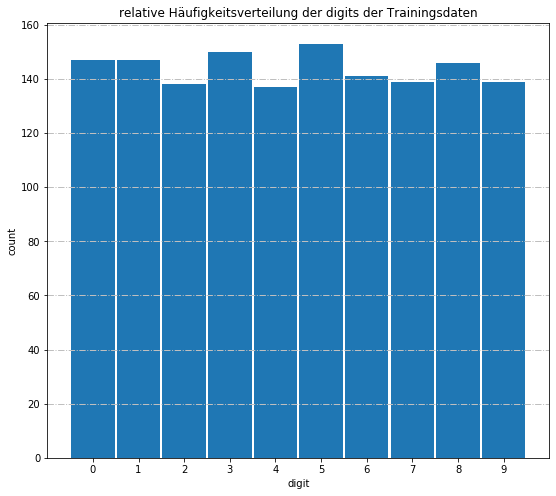

In [50]:
####################
# explore trainingset
####################

# Häufigkeitsverteilung y (target)
fig = plt.figure(figsize=(9, 8))

labels, counts = np.unique(y_train, return_counts=True)

print(labels,'\n',counts)

plt.bar(labels, counts, align='center', width=0.95)
plt.gca().set_xticks(labels)
plt.xlabel('digit')
plt.xlim(-1,10)
plt.ylabel('count')
plt.title('relative Häufigkeitsverteilung der digits der Trainingsdaten')
plt.grid(color='0.75', linestyle='-.', linewidth=1, axis='y')
plt.show()

Zu sehen ist die Klassenverteilung des Datensets. Anzumerken ist, dass bis auf Klasse 0 und Klasse 1 die Anzahl bei jeder Klassen unterschiedlich ist. Die Klassen des Datensets also nicht ausgeglichen sind.

feature 0 (0):


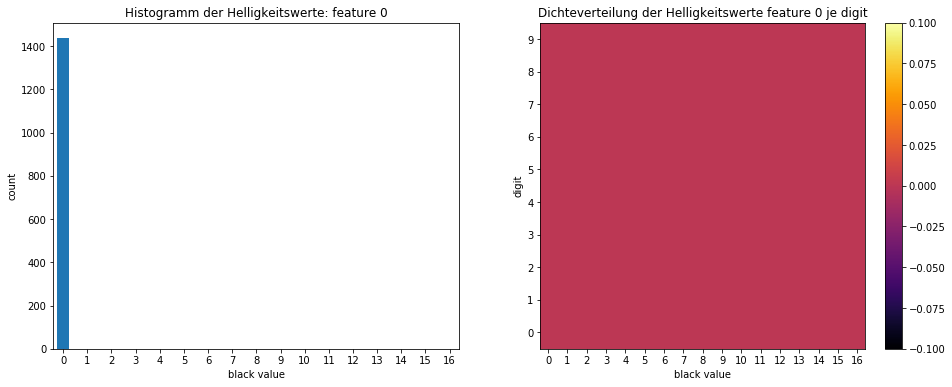

rows = 1437
all numeric = True (float64)
mean = 0.0
std = 0.0
max|min = 0.0|0.0 
 

feature 1 (1):


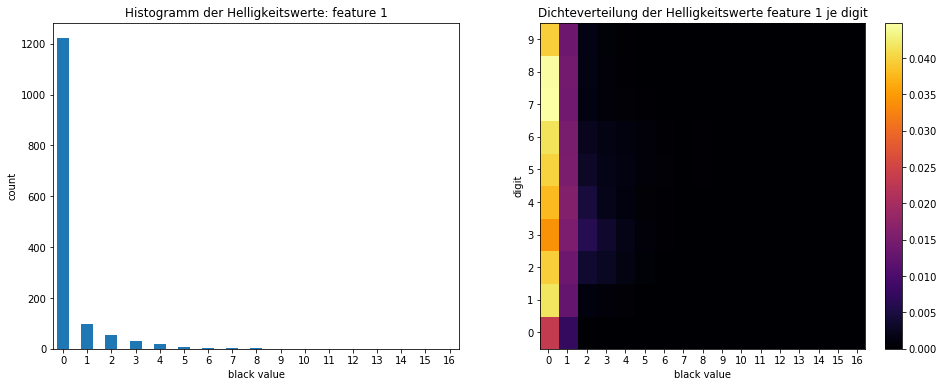

rows = 1437
all numeric = True (float64)
mean = 0.3089770354906054
std = 0.9080227727157915
max|min = 8.0|0.0 
 

feature 2 (2):


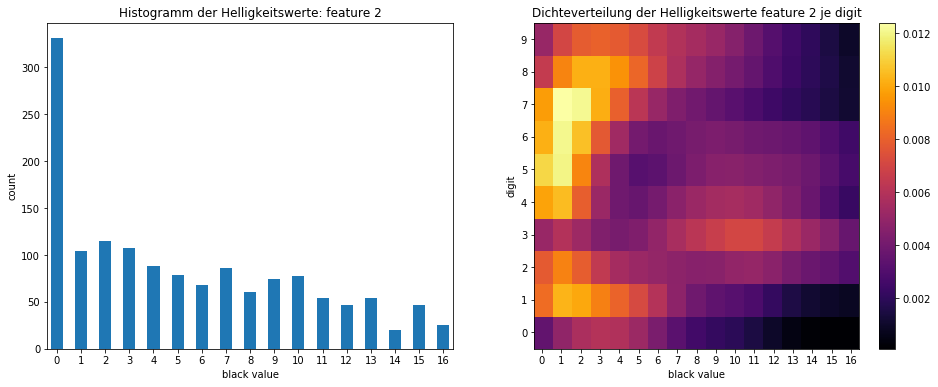

rows = 1437
all numeric = True (float64)
mean = 5.27696590118302
std = 4.756694551461193
max|min = 16.0|0.0 
 

feature 3 (3):


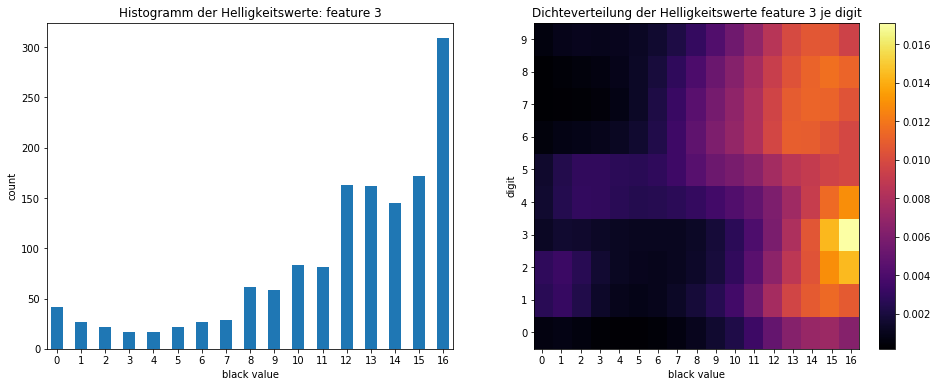

rows = 1437
all numeric = True (float64)
mean = 11.838552540013918
std = 4.24235725997737
max|min = 16.0|0.0 
 

feature 4 (4):


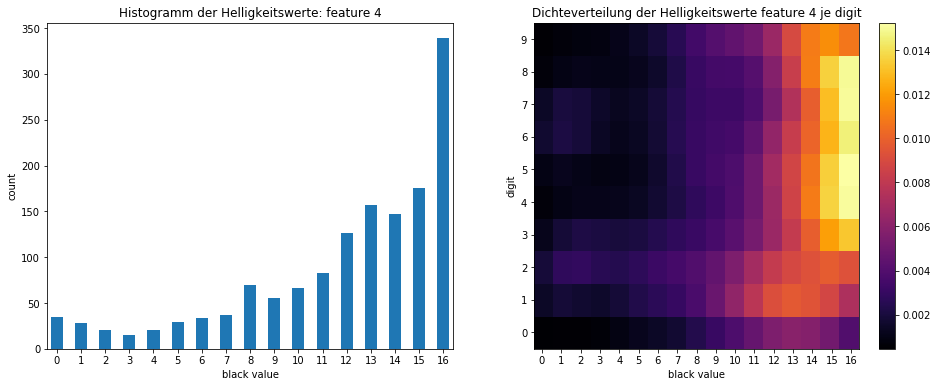

rows = 1437
all numeric = True (float64)
mean = 11.894919972164232
std = 4.2737838263895584
max|min = 16.0|0.0 
 

feature 5 (5):


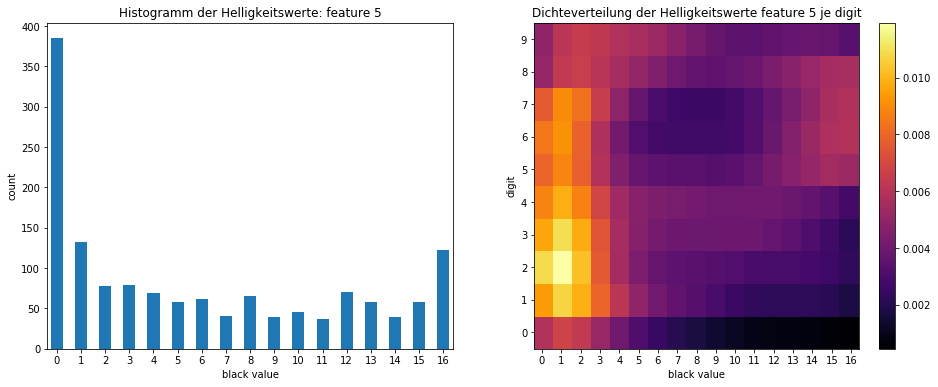

rows = 1437
all numeric = True (float64)
mean = 5.873347251217815
std = 5.687461284808417
max|min = 16.0|0.0 
 

feature 6 (6):


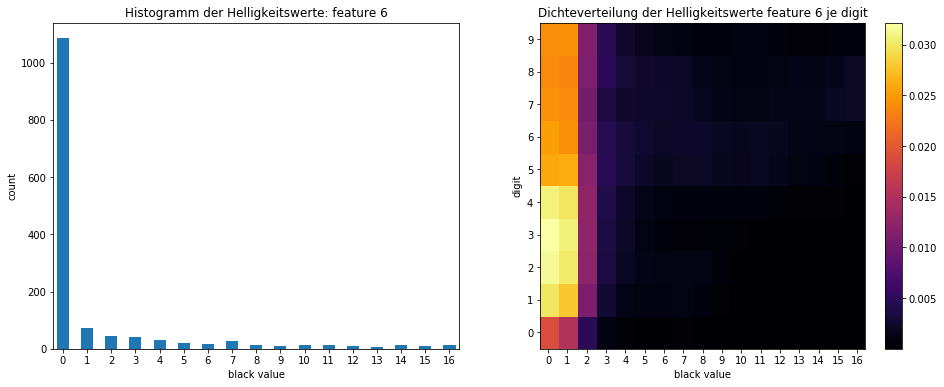

rows = 1437
all numeric = True (float64)
mean = 1.4022268615170494
std = 3.3371772763824787
max|min = 16.0|0.0 
 

feature 7 (7):


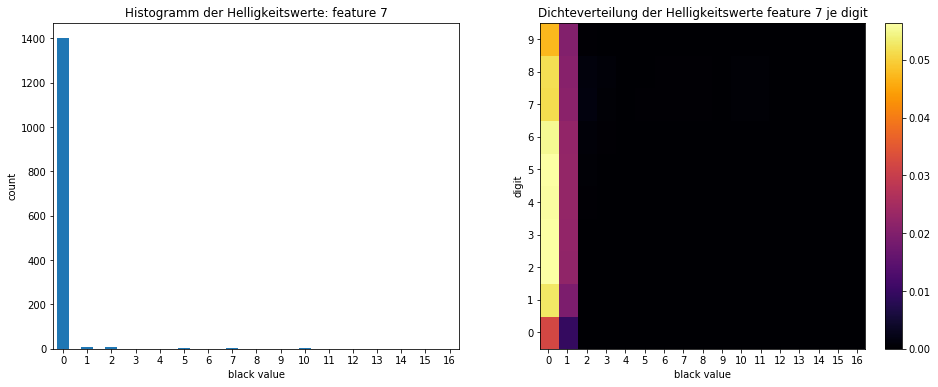

rows = 1437
all numeric = True (float64)
mean = 0.12734864300626306
std = 1.0603551086255054
max|min = 15.0|0.0 
 

feature 8 (8):


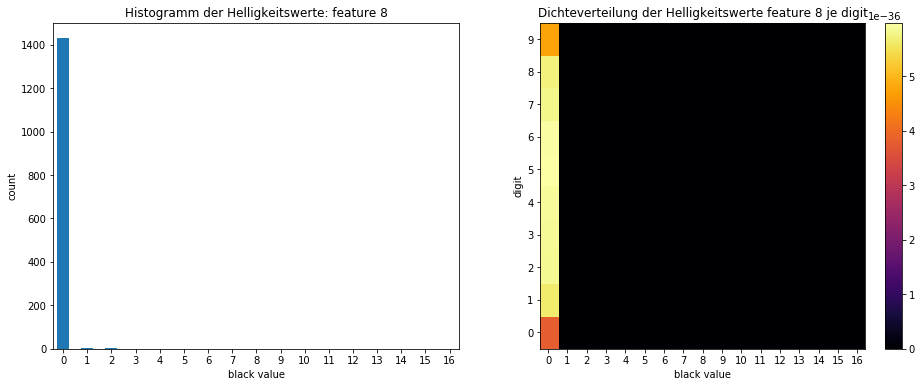

rows = 1437
all numeric = True (float64)
mean = 0.006958942240779402
std = 0.10528950901270526
max|min = 2.0|0.0 
 

feature 9 (9):


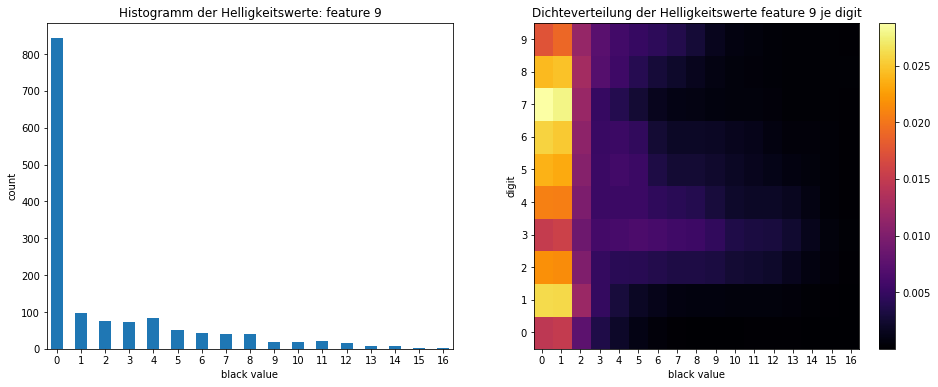

rows = 1437
all numeric = True (float64)
mean = 2.0382741823242867
std = 3.2677857555065564
max|min = 16.0|0.0 
 

feature 10 (10):


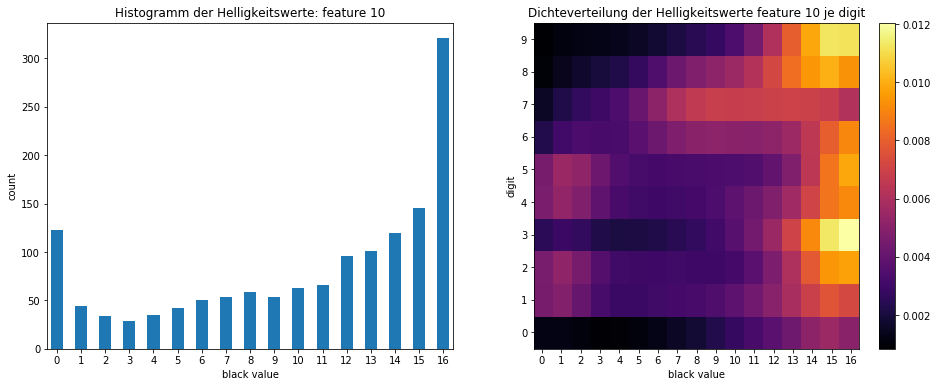

rows = 1437
all numeric = True (float64)
mean = 10.446764091858038
std = 5.376899573904525
max|min = 16.0|0.0 
 

feature 11 (11):


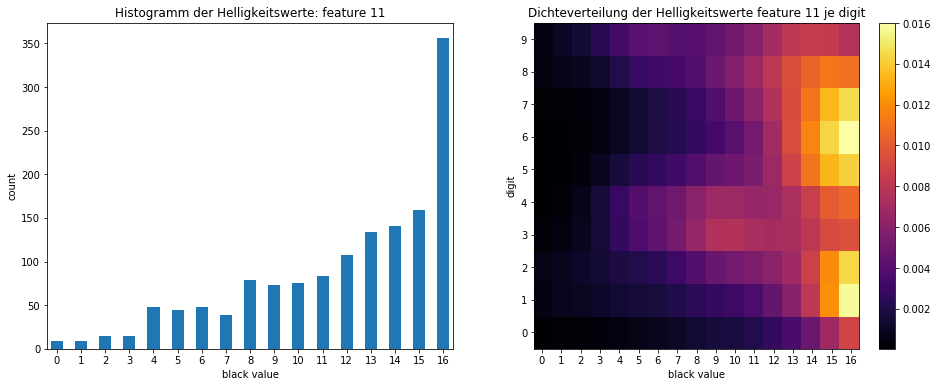

rows = 1437
all numeric = True (float64)
mean = 11.91231732776618
std = 4.017961758135452
max|min = 16.0|0.0 
 

feature 12 (12):


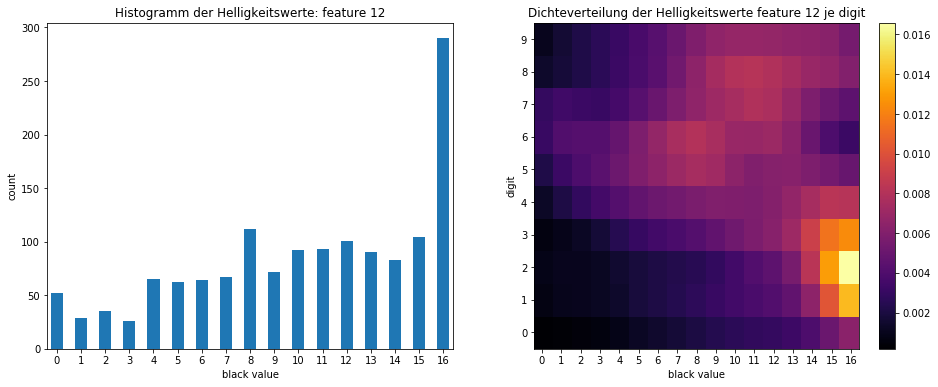

rows = 1437
all numeric = True (float64)
mean = 10.320807237299931
std = 4.764978059828867
max|min = 16.0|0.0 
 

feature 13 (13):


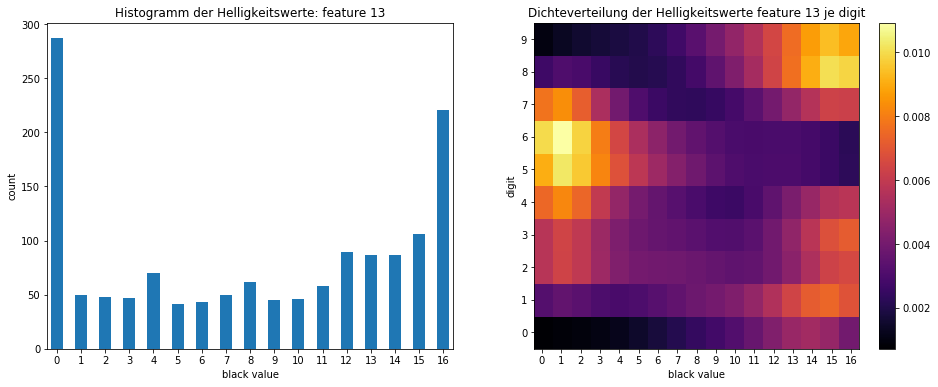

rows = 1437
all numeric = True (float64)
mean = 8.296450939457202
std = 6.022788543275903
max|min = 16.0|0.0 
 

feature 14 (14):


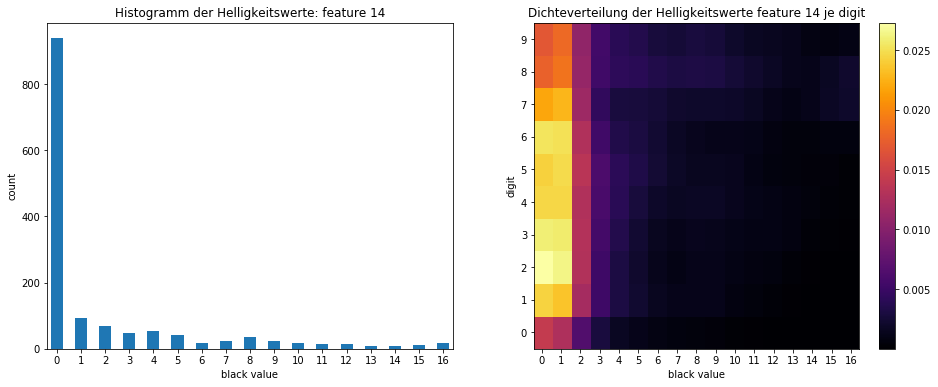

rows = 1437
all numeric = True (float64)
mean = 1.9060542797494782
std = 3.6268462126316923
max|min = 16.0|0.0 
 

feature 15 (15):


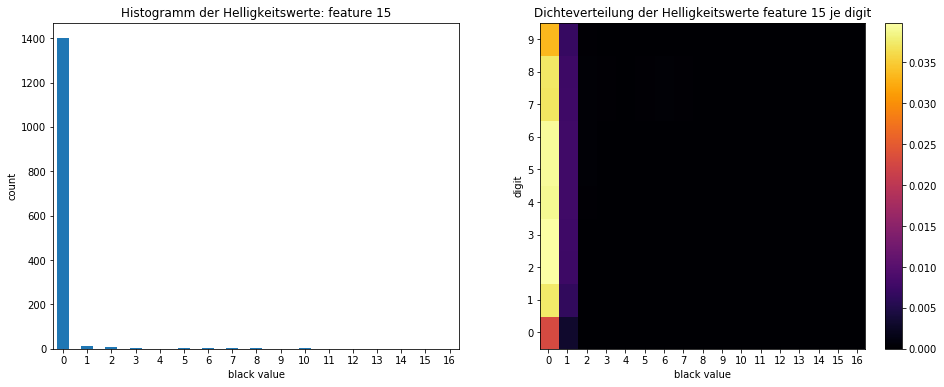

rows = 1437
all numeric = True (float64)
mean = 0.10020876826722339
std = 0.792084157156144
max|min = 11.0|0.0 
 

feature 16 (16):


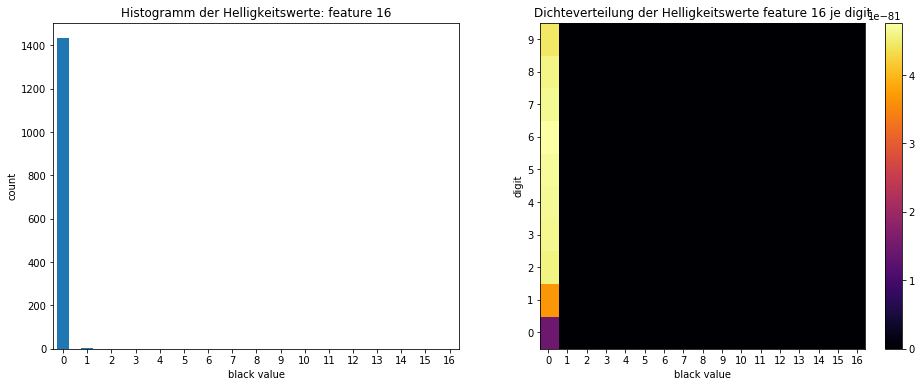

rows = 1437
all numeric = True (float64)
mean = 0.003479471120389701
std = 0.06970762403975592
max|min = 2.0|0.0 
 

feature 17 (17):


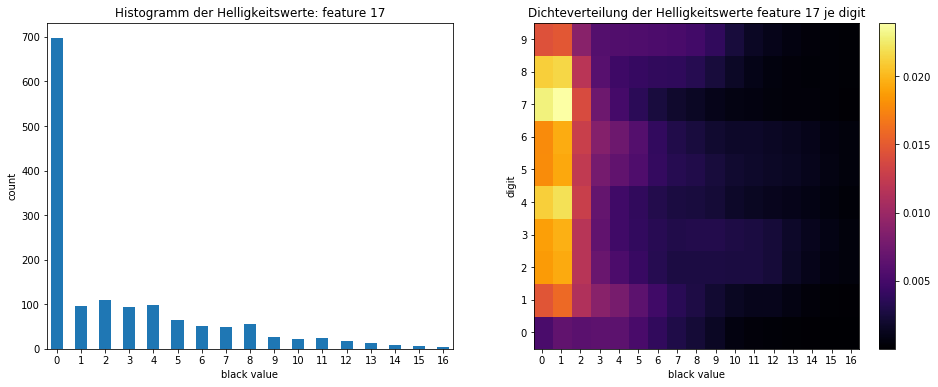

rows = 1437
all numeric = True (float64)
mean = 2.6443980514961725
std = 3.594754490908348
max|min = 16.0|0.0 
 

feature 18 (18):


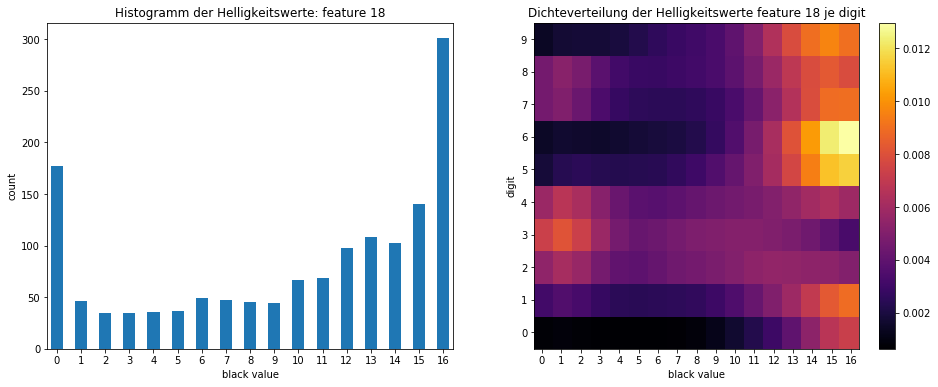

rows = 1437
all numeric = True (float64)
mean = 9.948503827418232
std = 5.685211944389563
max|min = 16.0|0.0 
 

feature 19 (19):


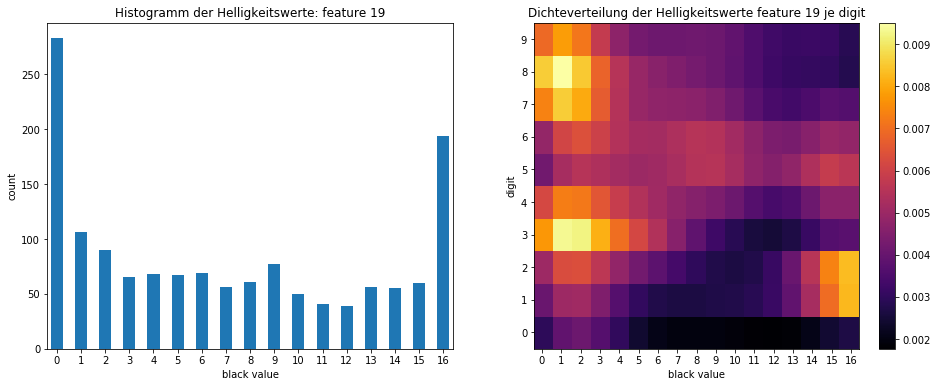

rows = 1437
all numeric = True (float64)
mean = 6.95615866388309
std = 5.817584147541509
max|min = 16.0|0.0 
 

feature 20 (20):


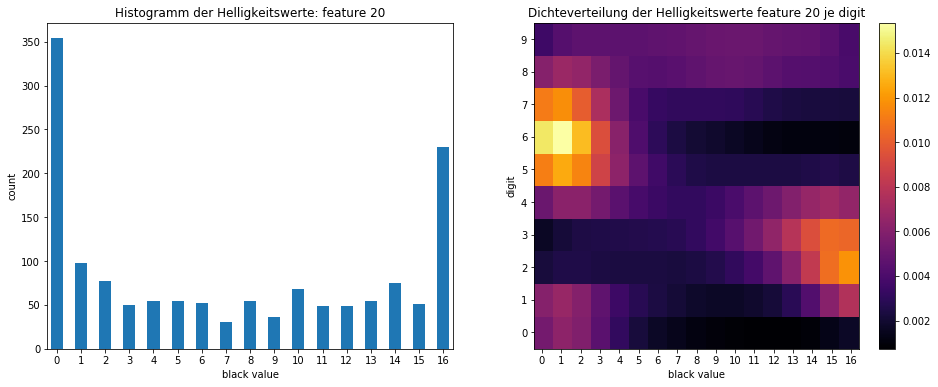

rows = 1437
all numeric = True (float64)
mean = 7.087682672233821
std = 6.168304733629506
max|min = 16.0|0.0 
 

feature 21 (21):


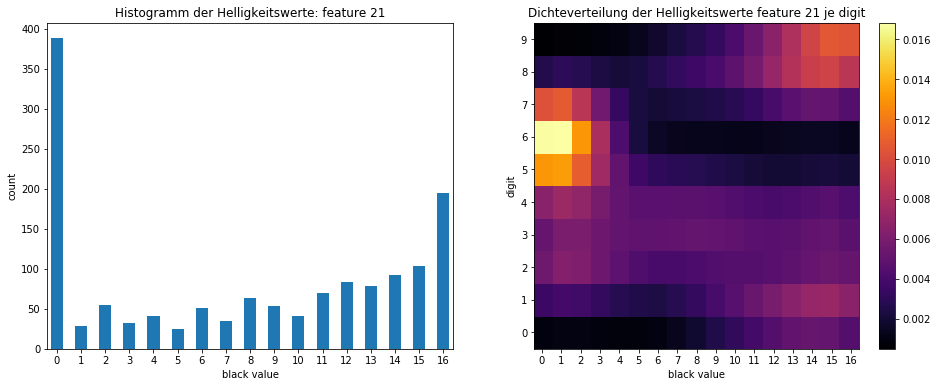

rows = 1437
all numeric = True (float64)
mean = 7.8190675017397355
std = 6.19476048337488
max|min = 16.0|0.0 
 

feature 22 (22):


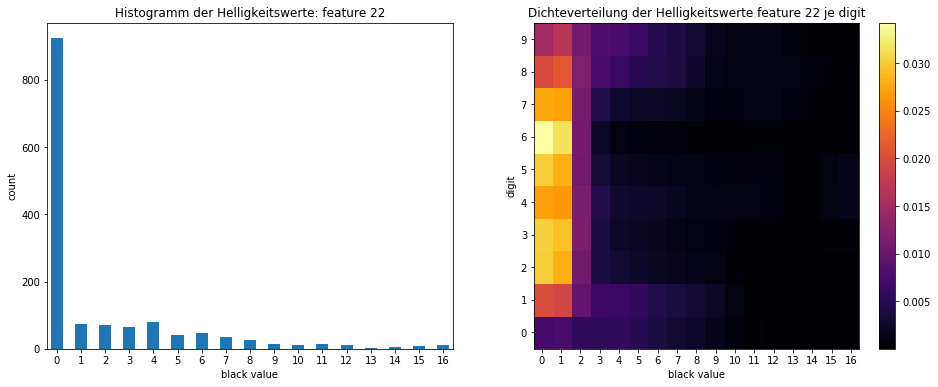

rows = 1437
all numeric = True (float64)
mean = 1.79053583855254
std = 3.243316696276848
max|min = 16.0|0.0 
 

feature 23 (23):


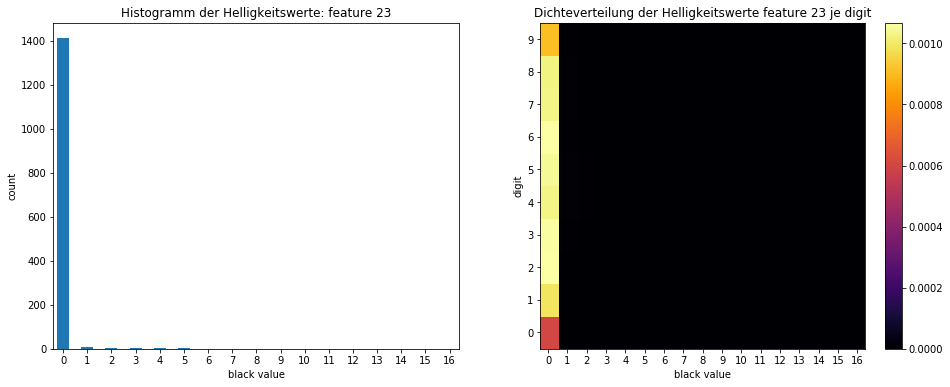

rows = 1437
all numeric = True (float64)
mean = 0.04314544189283229
std = 0.3959827697433849
max|min = 8.0|0.0 
 

feature 24 (24):


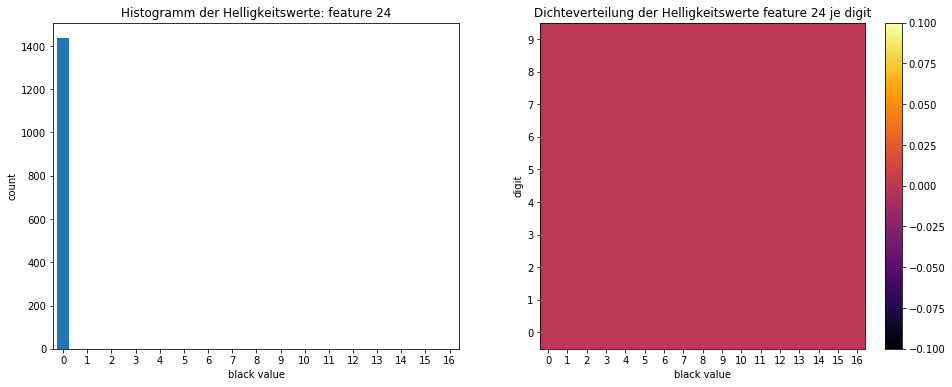

rows = 1437
all numeric = True (float64)
mean = 0.0006958942240779402
std = 0.02637062675225667
max|min = 1.0|0.0 
 

feature 25 (25):


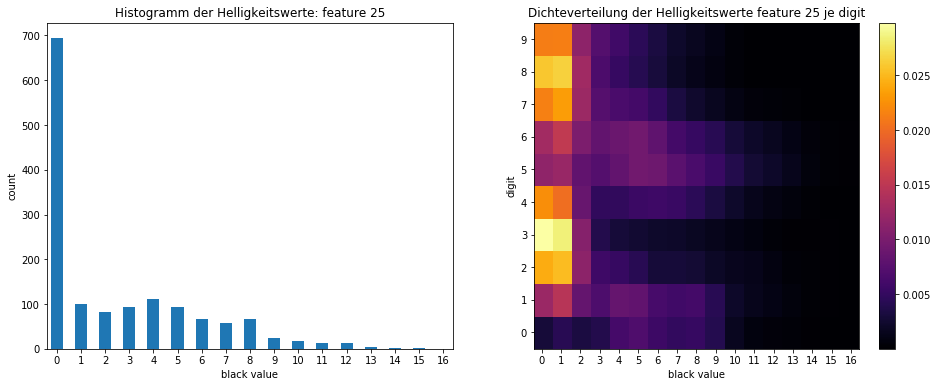

rows = 1437
all numeric = True (float64)
mean = 2.468336812804454
std = 3.141945698627902
max|min = 15.0|0.0 
 

feature 26 (26):


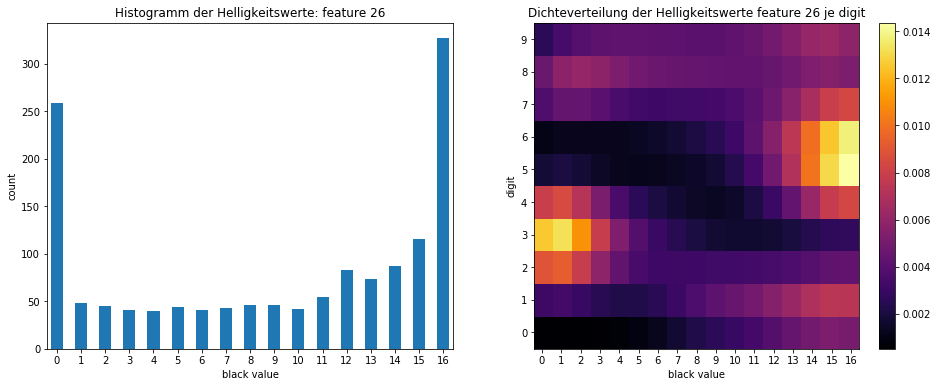

rows = 1437
all numeric = True (float64)
mean = 9.146137787056368
std = 6.161778106976023
max|min = 16.0|0.0 
 

feature 27 (27):


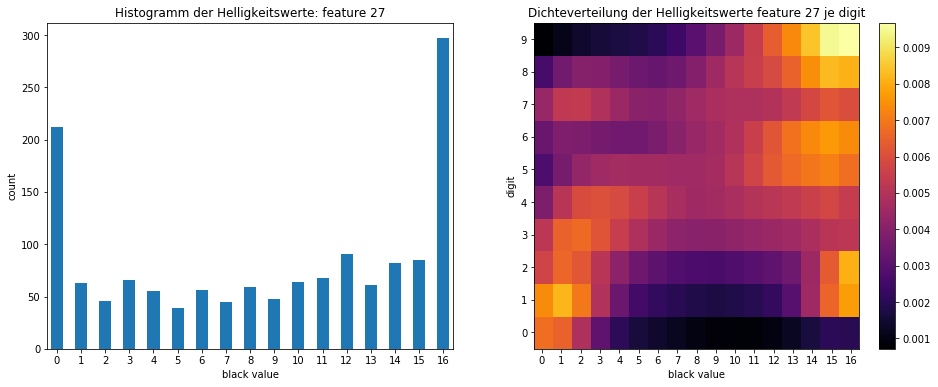

rows = 1437
all numeric = True (float64)
mean = 8.887265135699373
std = 5.9194157580944555
max|min = 16.0|0.0 
 

feature 28 (28):


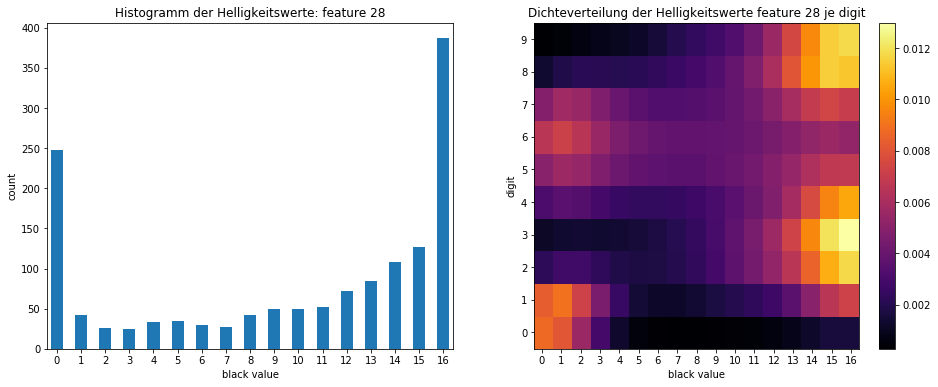

rows = 1437
all numeric = True (float64)
mean = 9.92205984690327
std = 6.131093432869055
max|min = 16.0|0.0 
 

feature 29 (29):


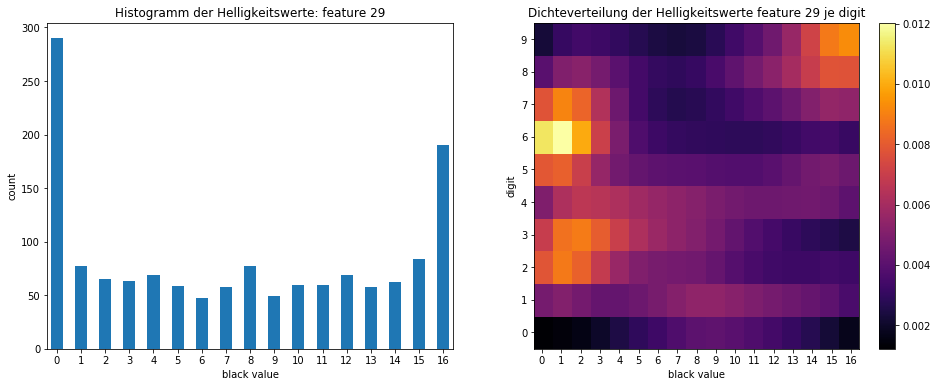

rows = 1437
all numeric = True (float64)
mean = 7.461377870563674
std = 5.875245976983436
max|min = 16.0|0.0 
 

feature 30 (30):


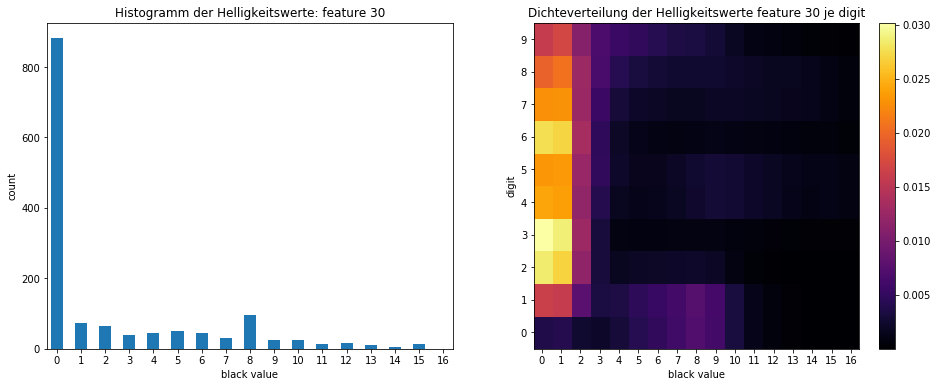

rows = 1437
all numeric = True (float64)
mean = 2.2748782185107865
std = 3.660660270259676
max|min = 15.0|0.0 
 

feature 31 (31):


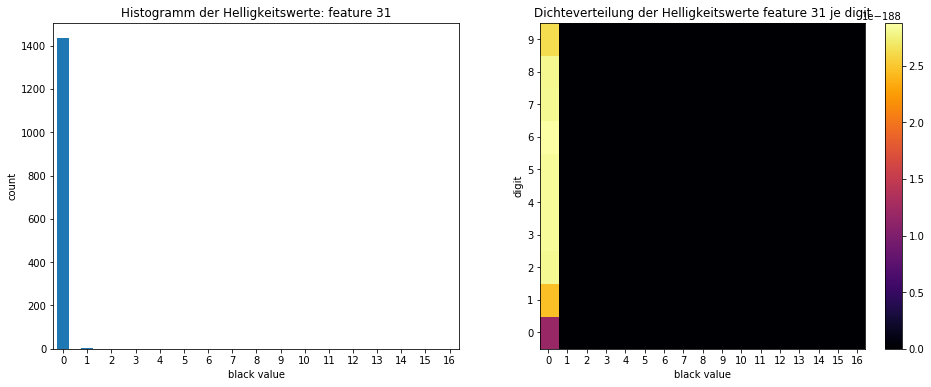

rows = 1437
all numeric = True (float64)
mean = 0.0020876826722338203
std = 0.04564344699180678
max|min = 1.0|0.0 
 

feature 32 (32):


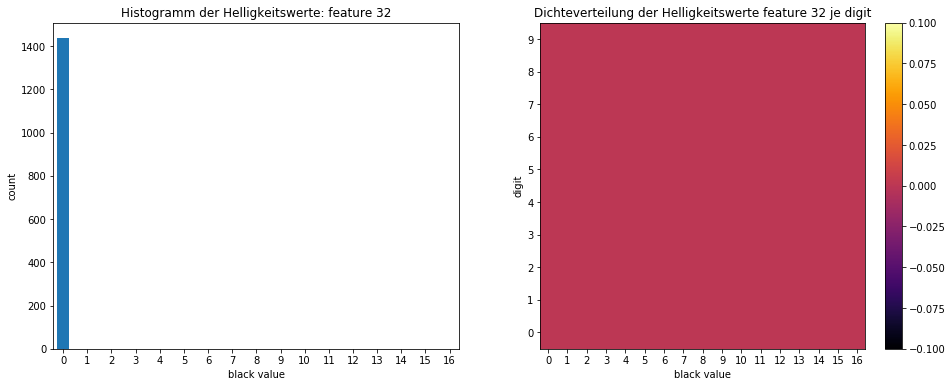

rows = 1437
all numeric = True (float64)
mean = 0.0
std = 0.0
max|min = 0.0|0.0 
 

feature 33 (33):


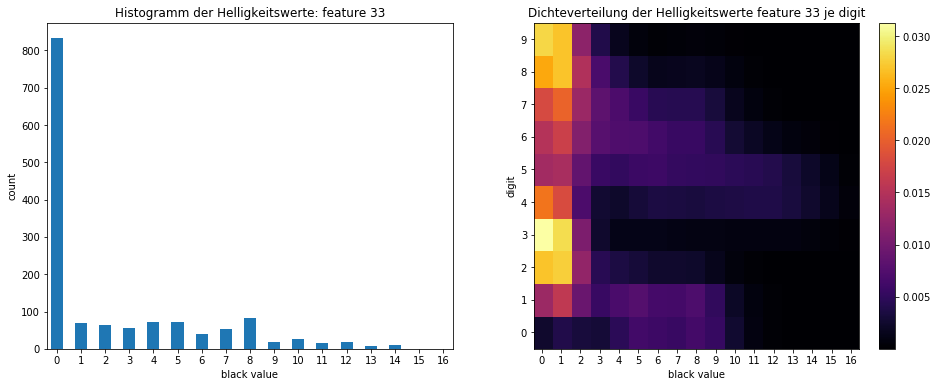

rows = 1437
all numeric = True (float64)
mean = 2.312456506610995
std = 3.4444298148100168
max|min = 14.0|0.0 
 

feature 34 (34):


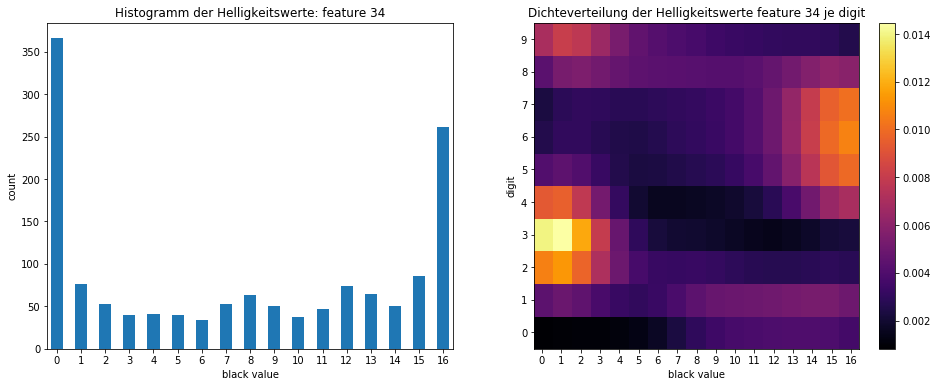

rows = 1437
all numeric = True (float64)
mean = 7.651356993736952
std = 6.31300972249696
max|min = 16.0|0.0 
 

feature 35 (35):


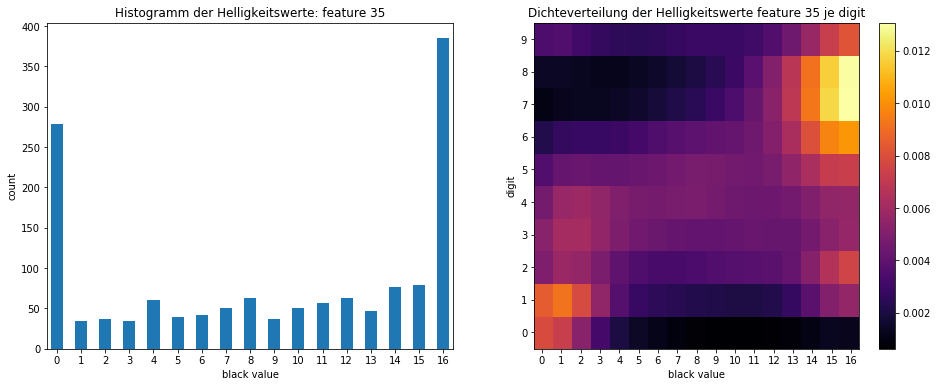

rows = 1437
all numeric = True (float64)
mean = 9.051496172581768
std = 6.2383748130775585
max|min = 16.0|0.0 
 

feature 36 (36):


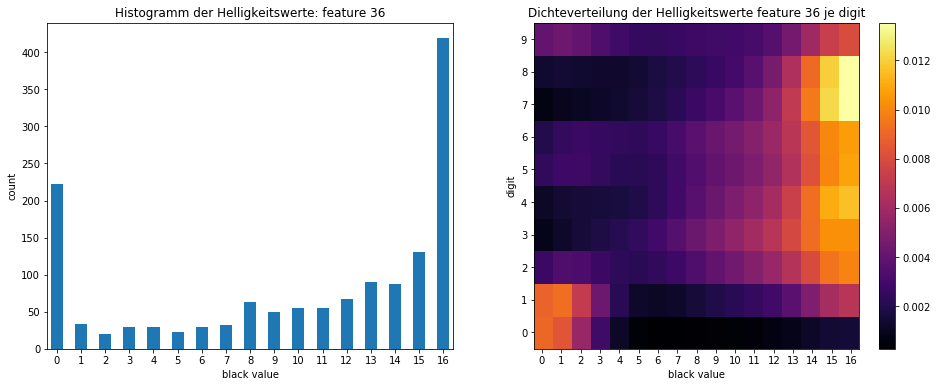

rows = 1437
all numeric = True (float64)
mean = 10.279053583855253
std = 5.963884550968594
max|min = 16.0|0.0 
 

feature 37 (37):


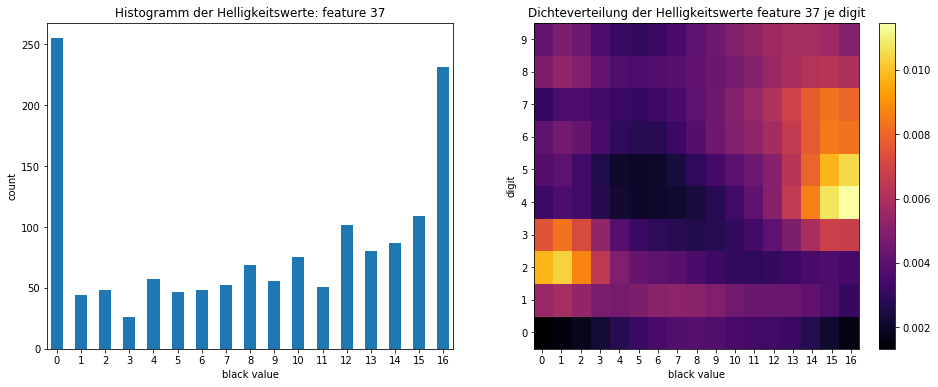

rows = 1437
all numeric = True (float64)
mean = 8.707724425887266
std = 5.864228410421803
max|min = 16.0|0.0 
 

feature 38 (38):


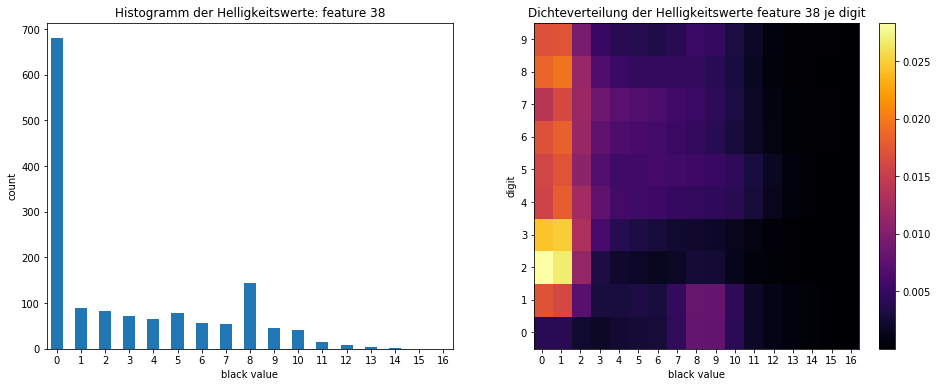

rows = 1437
all numeric = True (float64)
mean = 2.8810020876826723
std = 3.507884682499682
max|min = 14.0|0.0 
 

feature 39 (39):


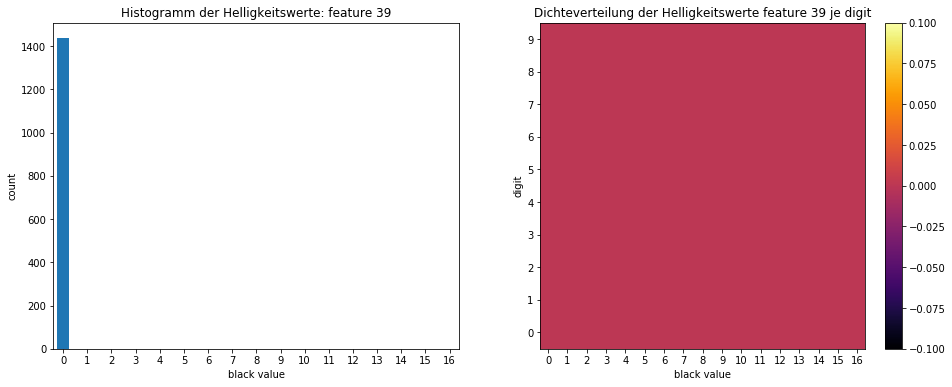

rows = 1437
all numeric = True (float64)
mean = 0.0
std = 0.0
max|min = 0.0|0.0 
 

feature 40 (40):


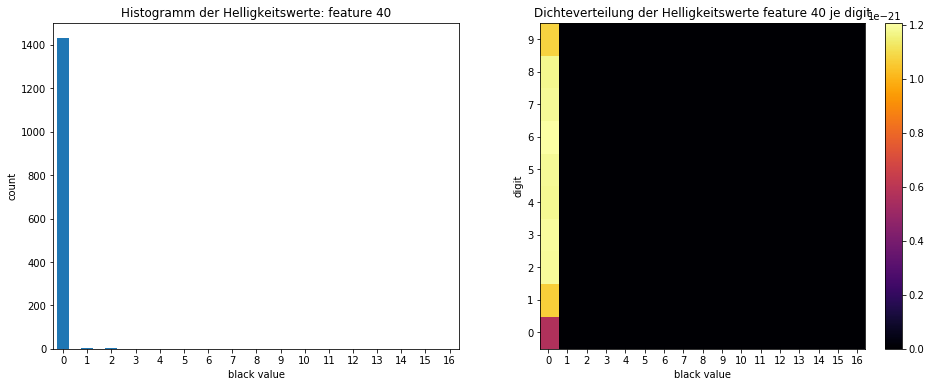

rows = 1437
all numeric = True (float64)
mean = 0.007654836464857342
std = 0.13685959056200875
max|min = 4.0|0.0 
 

feature 41 (41):


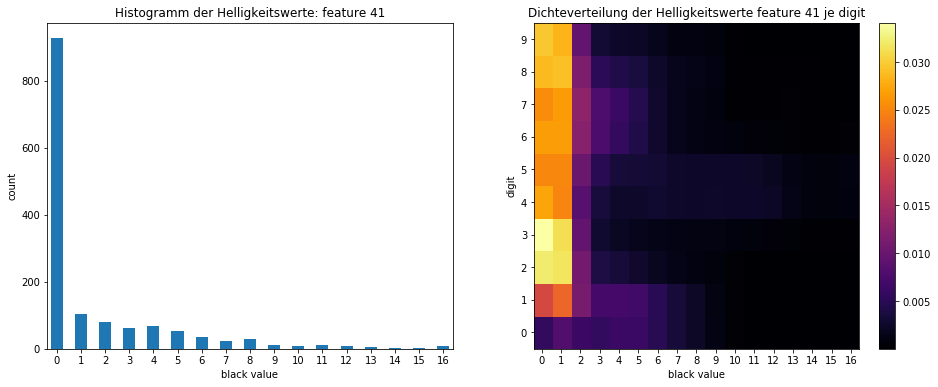

rows = 1437
all numeric = True (float64)
mean = 1.5483646485734168
std = 2.8696924512454234
max|min = 16.0|0.0 
 

feature 42 (42):


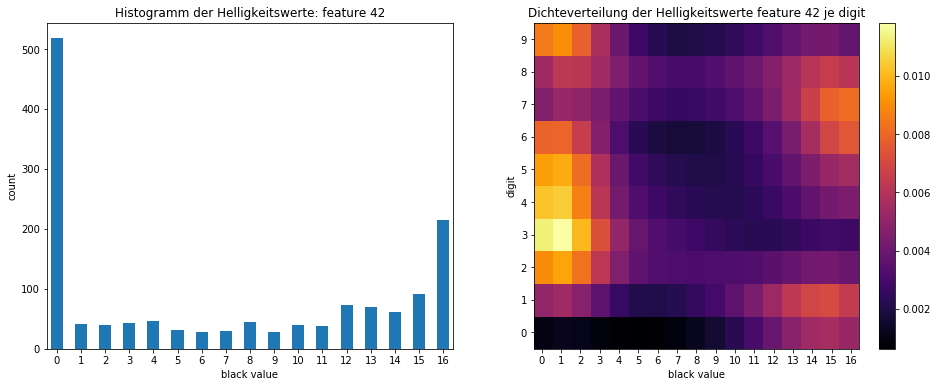

rows = 1437
all numeric = True (float64)
mean = 6.842727905358386
std = 6.5041315763145375
max|min = 16.0|0.0 
 

feature 43 (43):


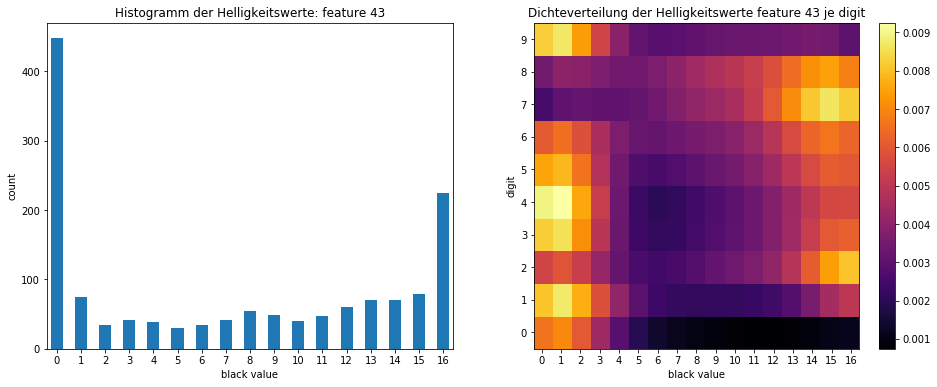

rows = 1437
all numeric = True (float64)
mean = 7.142658315935978
std = 6.392614641298623
max|min = 16.0|0.0 
 

feature 44 (44):


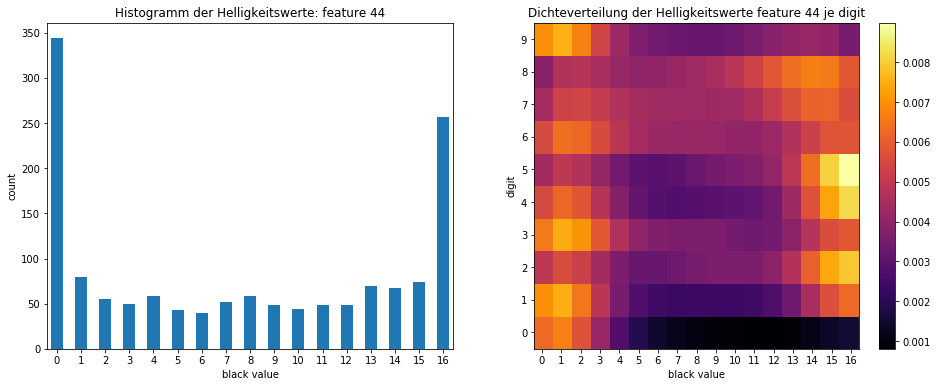

rows = 1437
all numeric = True (float64)
mean = 7.58803061934586
std = 6.249070306728526
max|min = 16.0|0.0 
 

feature 45 (45):


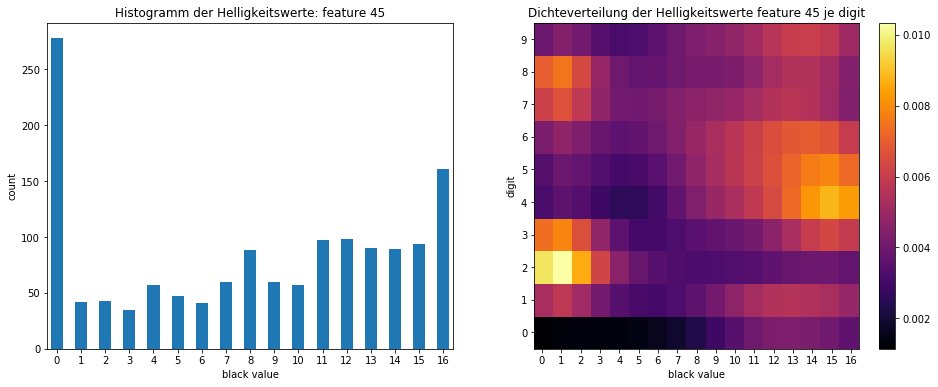

rows = 1437
all numeric = True (float64)
mean = 8.22616562282533
std = 5.70996371055976
max|min = 16.0|0.0 
 

feature 46 (46):


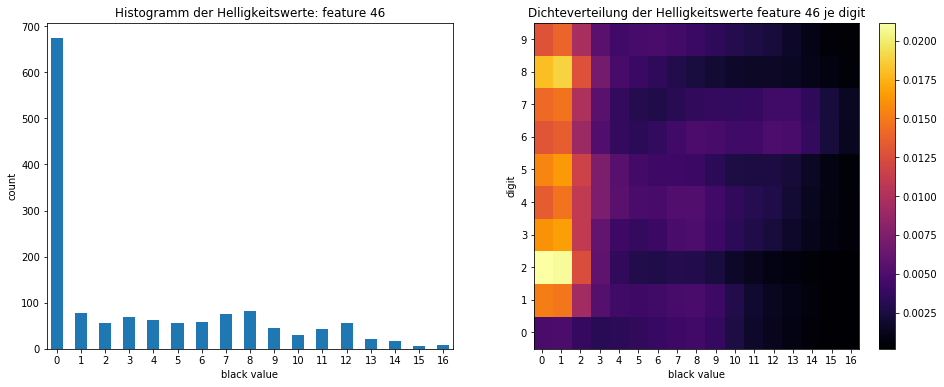

rows = 1437
all numeric = True (float64)
mean = 3.5059151009046623
std = 4.323166682097574
max|min = 16.0|0.0 
 

feature 47 (47):


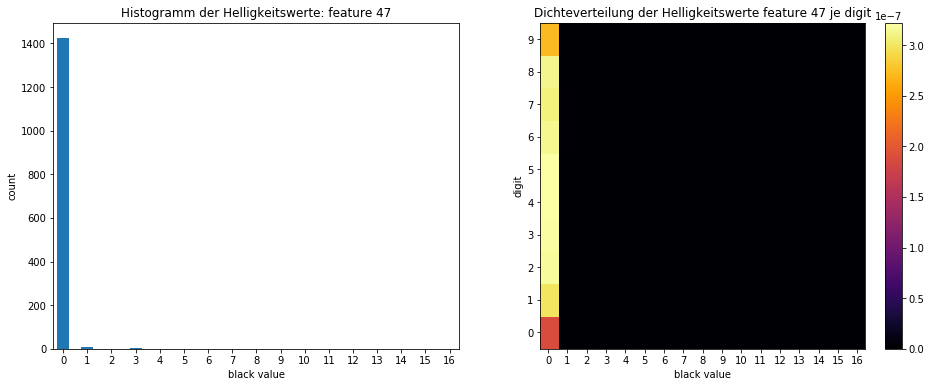

rows = 1437
all numeric = True (float64)
mean = 0.018789144050104383
std = 0.2509448992447485
max|min = 6.0|0.0 
 

feature 48 (48):


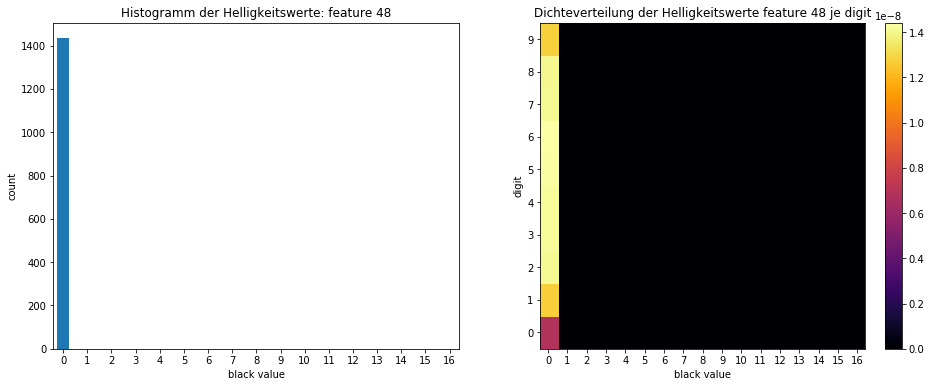

rows = 1437
all numeric = True (float64)
mean = 0.008350730688935281
std = 0.22677397972150257
max|min = 8.0|0.0 
 

feature 49 (49):


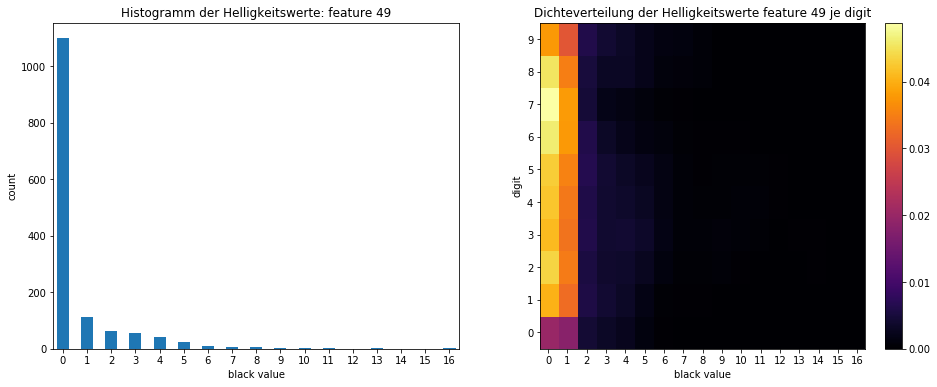

rows = 1437
all numeric = True (float64)
mean = 0.7042449547668754
std = 1.7309061962187628
max|min = 16.0|0.0 
 

feature 50 (50):


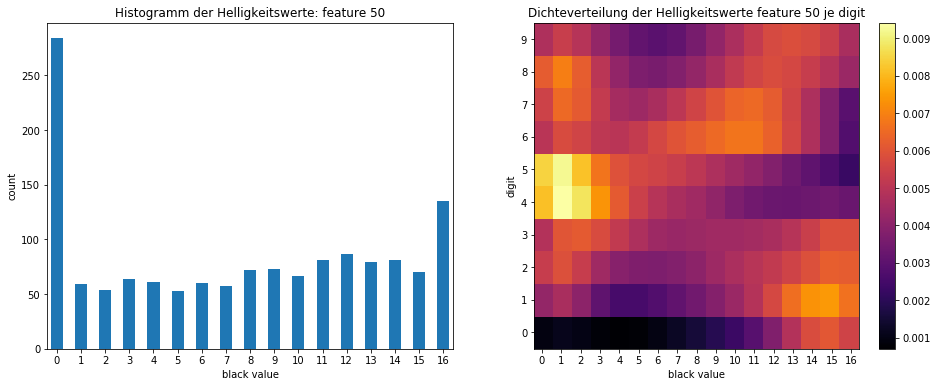

rows = 1437
all numeric = True (float64)
mean = 7.54070981210856
std = 5.62582204468743
max|min = 16.0|0.0 
 

feature 51 (51):


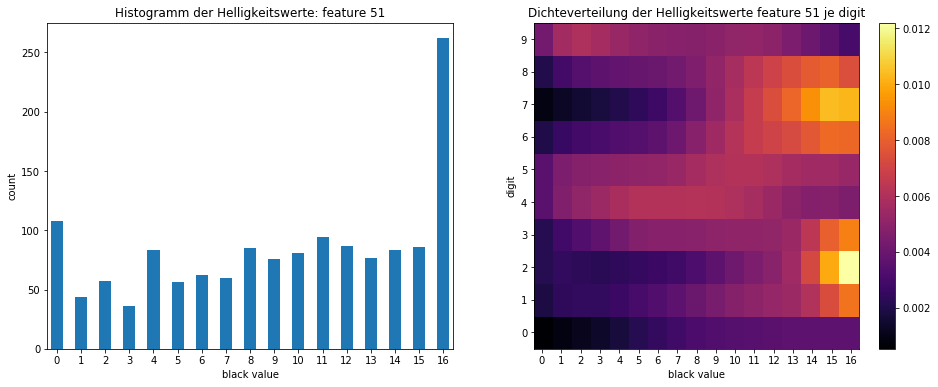

rows = 1437
all numeric = True (float64)
mean = 9.441196938065413
std = 5.256687502055869
max|min = 16.0|0.0 
 

feature 52 (52):


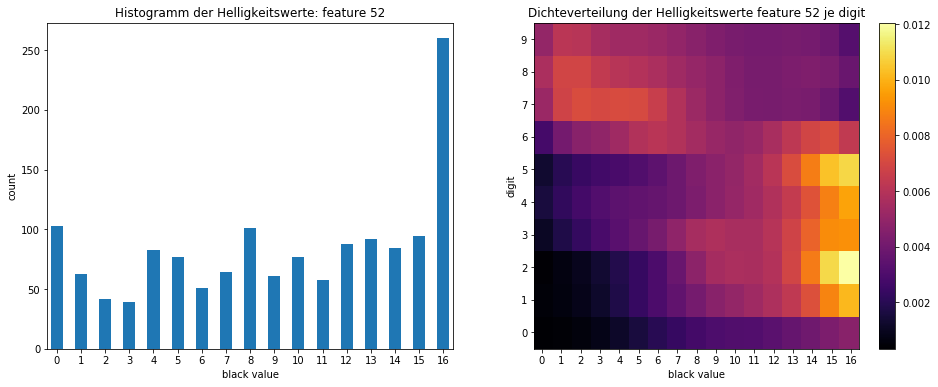

rows = 1437
all numeric = True (float64)
mean = 9.393180236604037
std = 5.311117602942774
max|min = 16.0|0.0 
 

feature 53 (53):


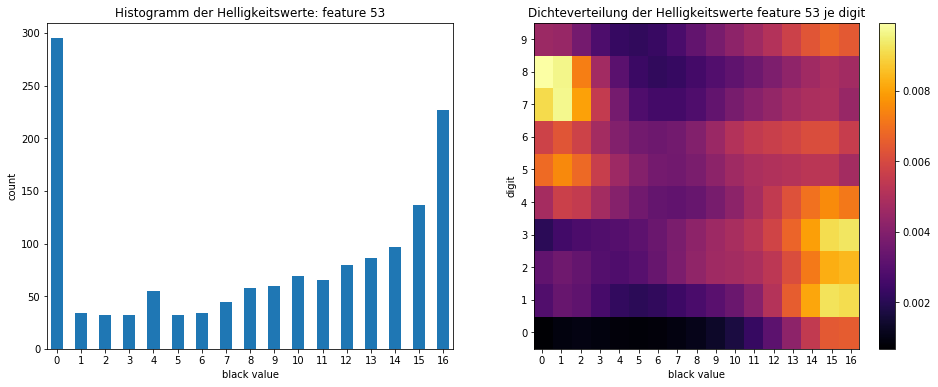

rows = 1437
all numeric = True (float64)
mean = 8.78079331941545
std = 6.018641297901178
max|min = 16.0|0.0 
 

feature 54 (54):


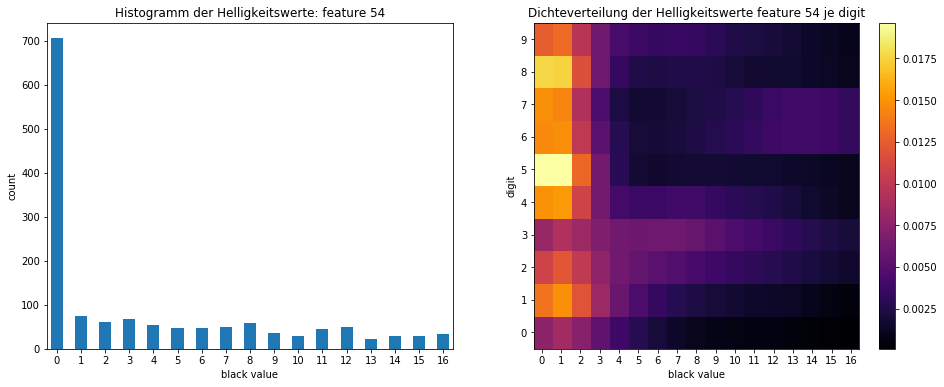

rows = 1437
all numeric = True (float64)
mean = 3.7035490605427976
std = 4.881883335245739
max|min = 16.0|0.0 
 

feature 55 (55):


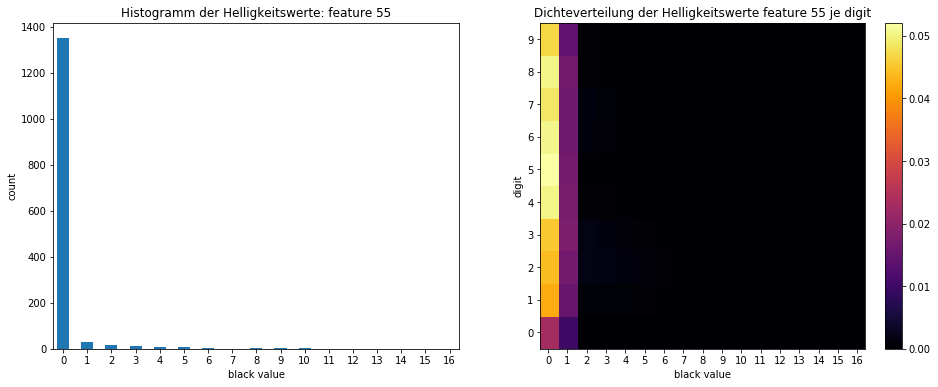

rows = 1437
all numeric = True (float64)
mean = 0.1885873347251218
std = 0.9620107798943368
max|min = 13.0|0.0 
 

feature 56 (56):


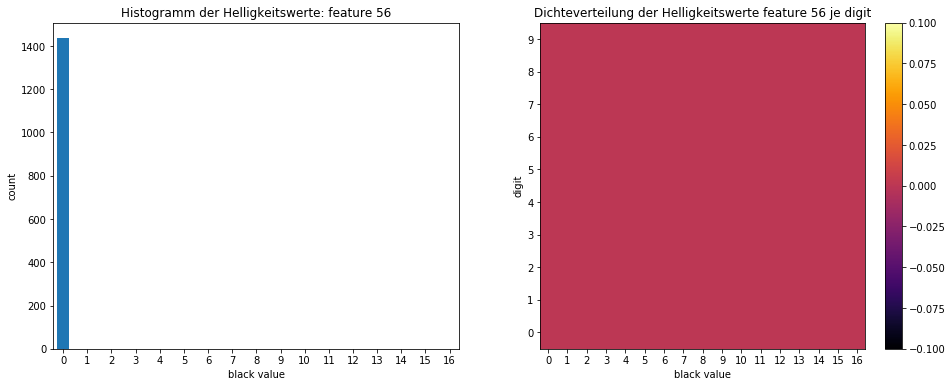

rows = 1437
all numeric = True (float64)
mean = 0.0006958942240779402
std = 0.026370626752256668
max|min = 1.0|0.0 
 

feature 57 (57):


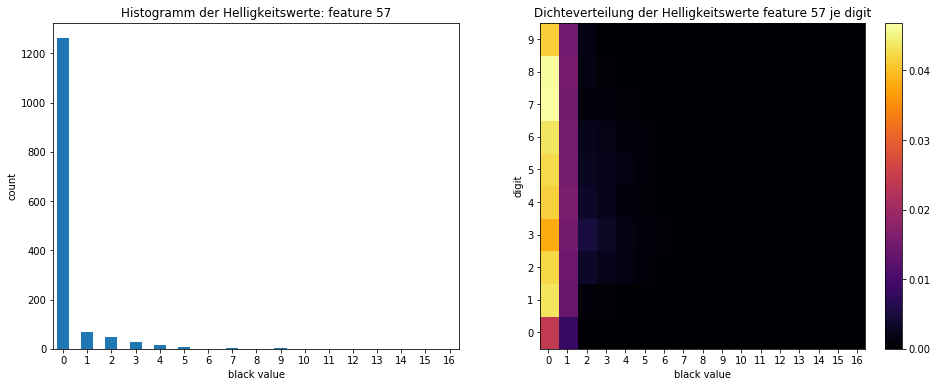

rows = 1437
all numeric = True (float64)
mean = 0.2783576896311761
std = 0.929174896118362
max|min = 9.0|0.0 
 

feature 58 (58):


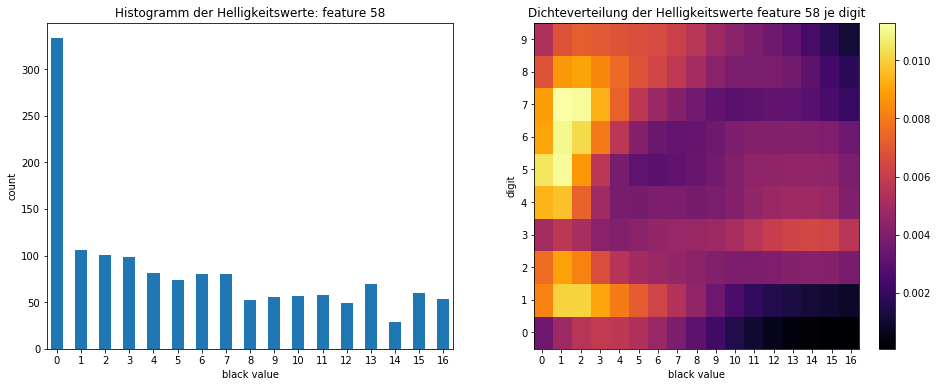

rows = 1437
all numeric = True (float64)
mean = 5.647877522616562
std = 5.123378676715896
max|min = 16.0|0.0 
 

feature 59 (59):


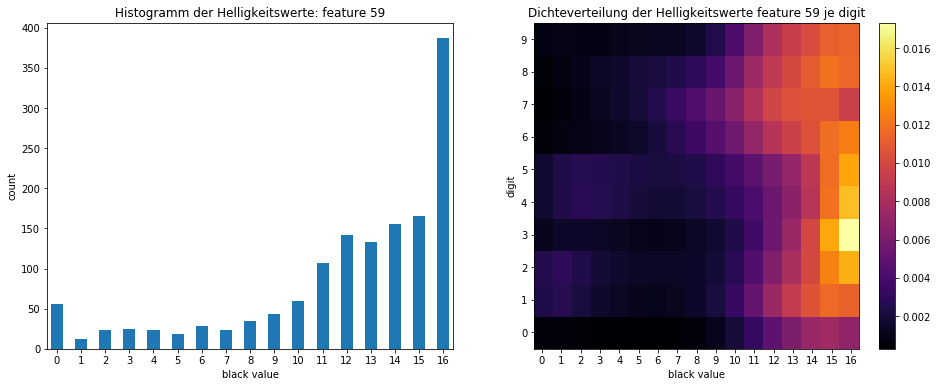

rows = 1437
all numeric = True (float64)
mean = 12.0946416144746
std = 4.376435343863748
max|min = 16.0|0.0 
 

feature 60 (60):


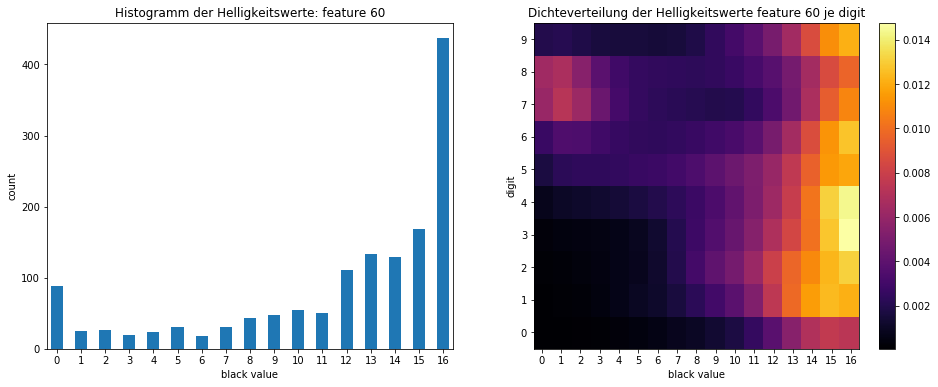

rows = 1437
all numeric = True (float64)
mean = 11.80375782881002
std = 4.934974503746357
max|min = 16.0|0.0 
 

feature 61 (61):


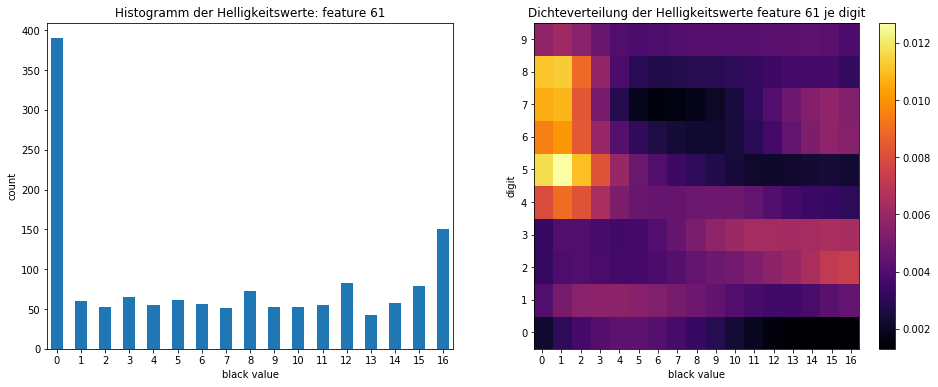

rows = 1437
all numeric = True (float64)
mean = 6.7633959638135
std = 5.87870640737783
max|min = 16.0|0.0 
 

feature 62 (62):


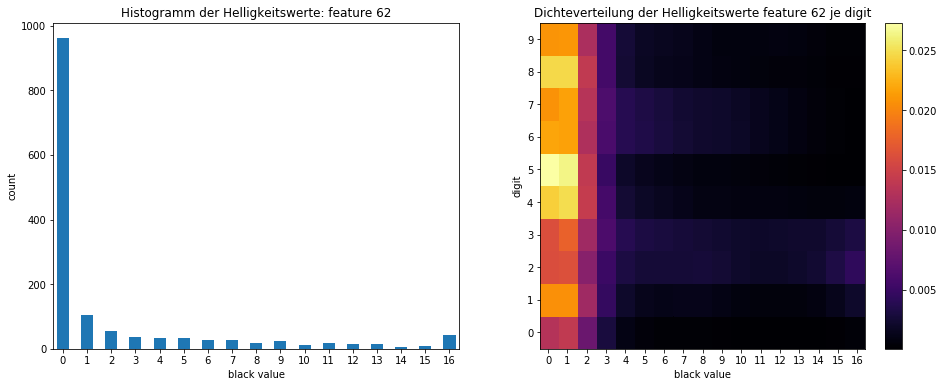

rows = 1437
all numeric = True (float64)
mean = 2.0591510090466247
std = 4.094055313547977
max|min = 16.0|0.0 
 

feature 63 (63):


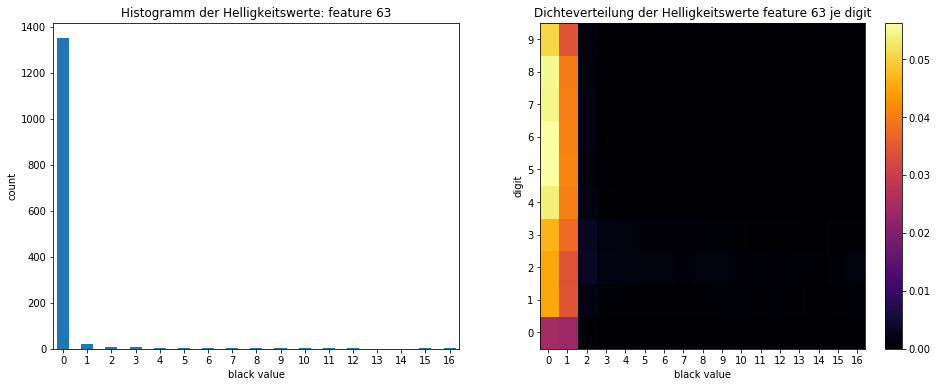

rows = 1437
all numeric = True (float64)
mean = 0.34725121781489215
std = 1.8003559615383296
max|min = 16.0|0.0 
 



In [118]:
mean_train, std_train = [], []
coeffs = []



labels = np.arange(-0,17,1)
xmax = 16.4
xmin = -0.4

for ind, col in enumerate(X_train.T):

    # print(df[col].describe())
    mean, std = lr.StandardScaler_fit(col)
    mean_train.append(mean)
    std_train.append(std)
    print(f'feature {ind} ({ind}):')
    fig1 = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs[0])
    ax.set_xlabel('black value')
    ax.set_ylabel("count")
    ax.set_title(f"Histogramm der Helligkeitswerte: feature {ind}")
    
    label, counts = np.unique(col, return_counts=True)

    ax.bar(label, counts, align='center', width=0.5)
    ax.set_xticks(labels)
    ax.set_xlim(xmin,xmax)
    ##
    ##
    
    
   # mat = np.array([[col],[y_train]])
    
    # Verteilungsdichte bestimmen
    # random offset um die covarianz numerisch betimmen zu können
    rand = 0.0001*np.random.rand(np.size(col,0))-0.0001
    # KDE
    k = gaussian_kde(np.vstack([col+rand, y_train]))
    xi, yi = np.mgrid[xmin:xmax:col.size**0.4*1j, y_train.min()-0.5:y_train.max()+0.5:y_train.size**0.3333*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    ax2 = plt.subplot(gs[1])
    ax2.set_xlabel('black value')
    ax2.set_ylabel("digit")
    ax2.set_xticks(labels)
    ax2.set_yticks(targets)
    ax2.set_ylim(-0.5,9.5)
    ax2.set_xlim(xmin,xmax)
    #im = ax2.matshow(mat)
    
    #plot density
    #ax2.scatter(col, y_train, alpha=0.1)#, c=col, cmap=cm.cividis)
    #im = ax2.pcolormesh(xedges, yedges, Z.T)
    im = ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = cm.inferno, alpha=1)#cm.cividis GnBu YlOrBr viridis magma
    plt.colorbar(im)
    
    ##
    coeff = np.mean(np.corrcoef(col, y_train.T))
    coeffs.append(coeff)
    ax2.set_title(f"Dichteverteilung der Helligkeitswerte feature {ind} je digit")
    plt.show()

    #Feature beschreiben
    print(f'rows = {np.size(col)}\nall numeric = {not np.isnan(col).any()} ({col.dtype})\nmean = {mean}\nstd = {std}\nmax|min = {np.max(col)}|{np.min(col)}', '\n', '\n')


Die oberen Plots zeigen die statistische Verteilung jedes Features auf der linken Seite und die Dichteverteilung jedes Schwarzwertes pro digit, welches von diesem Feature beschrieben wurde, auf der rechten Seite.

Anzumerken ist hier, die Features im großen und ganzen nach einem Muster verteilt sind und sich dieses Muster kontinuierlich wiederholt. Feature 26-29, 34-37, 42-45, 50-53 sind in Ihrer Verteilung sehr ähnlich. Vermutlich handelt es sich dabei um Pixel auf den zentralen Spalten der Zahlmatrix.
Dazwischen sind die Features wenigen Schwarzwerten zugeteilt.

Anzumerken ist auch noch, dass die Visualisierung bei std = 0 derzeit noch fehlerhaft ist.

Eine weitere Visualisierungsmöglichkeit wäre hier ein Boxplot, welches weitere statistische Eigenschaften sowie Ausreißer besser Visualisiert werden.

Um einzelne Zahlen mittels logiostischer Regression klassifizieren zu können muss der target vektor neu definiert werden, da die logistische Regression ausschließlich binäre Klassifizierung ermöglicht.

Es wird nachfolgend für jede Zahl ein neuer target Vektor mit Zahl[1]/andere Zahl[2] definiert.

In [119]:
#X_train_9 =X_train[y_train==9]
y_train_t = []
y_test_t = []


for tar in targets:
    y_train_t.append(np.array([1 if y == tar else 0 for y in y_train]))
    y_test_t.append(np.array([1 if y == tar else 0 for y in y_test]))
    print(f'digit {tar}: +{len(y_train_t[tar][y_train_t[tar]==1])}/{len(y_train_t[tar][y_train_t[tar]==0])}- train label || +{len(y_test_t[tar][y_test_t[tar]==1])}/{len(y_test_t[tar][y_test_t[tar]==0])}- test label')
    #[147 147 138 150 137 153 141 139 146 139]

digit 0: +147/1290- train label || +31/329- test label
digit 1: +147/1290- train label || +35/325- test label
digit 2: +138/1299- train label || +39/321- test label
digit 3: +150/1287- train label || +33/327- test label
digit 4: +137/1300- train label || +44/316- test label
digit 5: +153/1284- train label || +29/331- test label
digit 6: +141/1296- train label || +40/320- test label
digit 7: +139/1298- train label || +40/320- test label
digit 8: +146/1291- train label || +28/332- test label
digit 9: +139/1298- train label || +41/319- test label


Es gilt noch zu untersuchen, inwiweit die nicht ausgeglichenen Klassenverteilungen im Datenset, die Vorhersagekraft des Klassifizierers, beeinträchtigt.

Dafür müsste man die Datensets weiter anpassen, sodass von jeder Klasse gleich viele Einträge vorhanden sind.

### Bestimmung der Lernrate mittels CV

Da der logistische Klassifizierer mittels Gradienten Abstiegsvefahren trainiert wird, ist es notwendig eine geeignete Schrittweite zu ermitteln, damit der Algorithmus das globale Minima in einer angemessenen Zeit findet.

Um einen statistisch aussagekräftigen Parameter zu ermitteln wird hierfür das Kreuzvaidierungsverfahren angewendet.

In [98]:
#############################################
# Kreuzvalidierung
etalist = np.arange(0.04,5.0,0.033)
print('CV with\n',etalist,'\n',len(etalist),'etas')

eta, rmse, J, counter = crossval(y_train_t[9],y_train_t[9], etalist, 5)

CV with
 [0.04  0.073 0.106 0.139 0.172 0.205 0.238 0.271 0.304 0.337 0.37  0.403
 0.436 0.469 0.502 0.535 0.568 0.601 0.634 0.667 0.7   0.733 0.766 0.799
 0.832 0.865 0.898 0.931 0.964 0.997 1.03  1.063 1.096 1.129 1.162 1.195
 1.228 1.261 1.294 1.327 1.36  1.393 1.426 1.459 1.492 1.525 1.558 1.591
 1.624 1.657 1.69  1.723 1.756 1.789 1.822 1.855 1.888 1.921 1.954 1.987
 2.02  2.053 2.086 2.119 2.152 2.185 2.218 2.251 2.284 2.317 2.35  2.383
 2.416 2.449 2.482 2.515 2.548 2.581 2.614 2.647 2.68  2.713 2.746 2.779
 2.812 2.845 2.878 2.911 2.944 2.977 3.01  3.043 3.076 3.109 3.142 3.175
 3.208 3.241 3.274 3.307 3.34  3.373 3.406 3.439 3.472 3.505 3.538 3.571
 3.604 3.637 3.67  3.703 3.736 3.769 3.802 3.835 3.868 3.901 3.934 3.967
 4.    4.033 4.066 4.099 4.132 4.165 4.198 4.231 4.264 4.297 4.33  4.363
 4.396 4.429 4.462 4.495 4.528 4.561 4.594 4.627 4.66  4.693 4.726 4.759
 4.792 4.825 4.858 4.891 4.924 4.957 4.99 ] 
 151 etas

##CV 0##
for eta 0.04 in 187745.6 iterations took 161.52842


##CV 28##
for eta 0.9640000000000003 in 7787.8 iterations took 6.718957424163818 seconds (1159.2567405365292 iter/sec):
rmse mean = 0.0006808491717181975 | diff: -1.314916613017348e-08
J mean = 0.0006726585903446334 | diff: -1.2903046425370365e-08
#########


##CV 29##
for eta 0.9970000000000003 in 7529.8 iterations took 6.483323097229004 seconds (1161.5952371338576 iter/sec):
rmse mean = 0.0006808606562061072 | diff: 1.1484487909708269e-08
J mean = 0.0006726700369308112 | diff: 1.1446586177716635e-08
#########


##CV 30##
for eta 1.0300000000000002 in 7288.8 iterations took 6.266201972961426 seconds (1163.3836984082789 iter/sec):
rmse mean = 0.0006808281632983994 | diff: -3.249290770777555e-08 new min!
J mean = 0.0006726380131533705 | diff: -3.202377744069857e-08 new min!
#########


##CV 31##
for eta 1.0630000000000004 in 7062.4 iterations took 6.069173812866211 seconds (1163.9143238956244 iter/sec):
rmse mean = 0.0006808311226618014 | diff: 2.959363402011035e-09
J mean = 0.00067264


##CV 60##
for eta 2.0200000000000005 in 3715.2 iterations took 3.2319109439849854 seconds (1149.7833087322335 iter/sec):
rmse mean = 0.0006808088441675875 | diff: 4.4807435865823475e-08
J mean = 0.0006726188181009911 | diff: 4.4337387364616274e-08
#########


##CV 61##
for eta 2.0530000000000004 in 3655.6 iterations took 3.1894757747650146 seconds (1146.2694473074316 iter/sec):
rmse mean = 0.0006807770420854336 | diff: -3.180208215389571e-08
J mean = 0.0006725874885322102 | diff: -3.132956878084889e-08
#########


##CV 62##
for eta 2.0860000000000007 in 3597.6 iterations took 3.1036314964294434 seconds (1159.286579533216 iter/sec):
rmse mean = 0.0006808000186890586 | diff: 2.297660362503024e-08
J mean = 0.0006726102477442274 | diff: 2.275921201716838e-08
#########


##CV 63##
for eta 2.1190000000000007 in 3541.6 iterations took 3.075411558151245 seconds (1151.7148801466383 iter/sec):
rmse mean = 0.0006807855900157914 | diff: -1.4428673267242662e-08
J mean = 0.000672596032931022 | diff


##CV 92##
for eta 3.076000000000001 in 2439.0 iterations took 2.1385228633880615 seconds (1140.5053360635843 iter/sec):
rmse mean = 0.0006807295065742105 | diff: -2.49656522707635e-08
J mean = 0.0006725408260227882 | diff: -2.409268358698636e-08
#########


##CV 93##
for eta 3.109000000000001 in 2413.0 iterations took 2.0801804065704346 seconds (1159.9944792598028 iter/sec):
rmse mean = 0.0006807518946894435 | diff: 2.2388115233007086e-08
J mean = 0.0006725629912394978 | diff: 2.2165216709692064e-08
#########


##CV 94##
for eta 3.142000000000001 in 2387.4 iterations took 2.0539464950561523 seconds (1162.6382086453127 iter/sec):
rmse mean = 0.0006808180927224647 | diff: 6.619803302125148e-08
J mean = 0.0006726278933707291 | diff: 6.490213123129442e-08
#########


##CV 95##
for eta 3.1750000000000007 in 2363.0 iterations took 2.0411148071289062 seconds (1157.6990571737078 iter/sec):
rmse mean = 0.0006806870168990081 | diff: -1.3107582345656555e-07 new min!
J mean = 0.000672498931768895


##CV 124##
for eta 4.1320000000000014 in 1815.0 iterations took 1.5682075023651123 seconds (1157.3705889534233 iter/sec):
rmse mean = 0.0006806850020904791 | diff: -9.120589836934118e-08
J mean = 0.000672497961201587 | diff: -8.937850258506057e-08
#########


##CV 125##
for eta 4.165000000000001 in 1800.4 iterations took 1.561560869216919 seconds (1153.3321471152656 iter/sec):
rmse mean = 0.0006807615018416212 | diff: 7.649975114205725e-08
J mean = 0.0006725728616034938 | diff: 7.490040190686904e-08
#########


##CV 126##
for eta 4.198000000000001 in 1786.4 iterations took 1.543635368347168 seconds (1157.6552031551544 iter/sec):
rmse mean = 0.0006806936127248406 | diff: -6.788911678060495e-08
J mean = 0.0006725057843156019 | diff: -6.707728789187746e-08
#########


##CV 127##
for eta 4.231000000000001 in 1772.4 iterations took 1.5285651683807373 seconds (1159.9100259948334 iter/sec):
rmse mean = 0.0006807100077231025 | diff: 1.639499826189012e-08
J mean = 0.0006725220195879731 | diff:

In [99]:

eta_min_rmse = eta[np.argmin(rmse)]
eta_min_J = eta[np.argmin(J)]

print(eta_min_rmse,eta_min_J)

4.495000000000001 4.495000000000001


Sowohl die Kreuzvalidierung mit dem rmse als auch mit dem logistischen Kosten ermitteln den selben Wert für eta. nachfolgend kann dies geplottet werden.

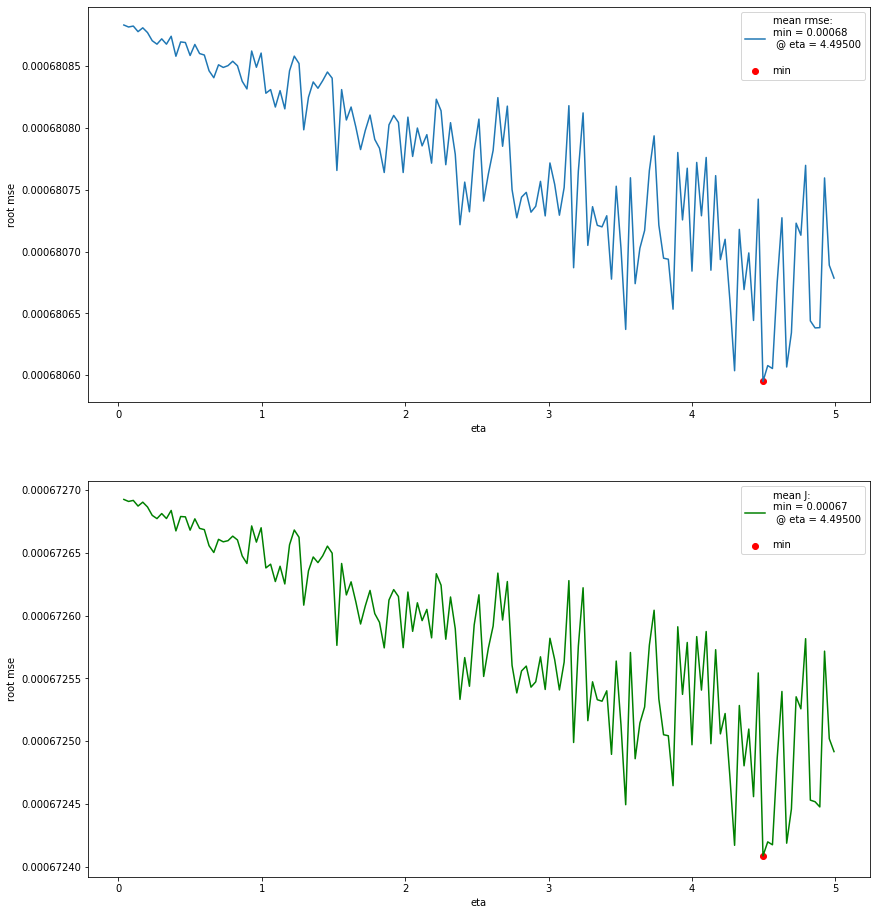

In [100]:
fig = plt.figure(figsize=(14, 16))
gs = gridspec.GridSpec(2, 1)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
#print(np.size(eta),np.size(rmse))
ax.plot(eta, rmse, label=f'mean rmse:\nmin = {np.min(rmse):.5f}\n @ eta = {eta_min_rmse:.5f}\n')
#print(np.size(eta),np.size(J))
ax2.plot(eta, J, label=f'mean J:\nmin = {np.min(J):.5f}\n @ eta = {eta_min_J:.5f}\n', color='g')
ax.scatter(eta_min_rmse, np.min(rmse), color='r', marker='o', label='min')
ax2.scatter(eta_min_J, np.min(J), color='r', marker='o', label='min')

ax.set_xlabel('eta')
ax.set_ylabel('root mse')

ax2.set_xlabel('eta')
ax2.set_ylabel('root mse')

ax.legend()
ax2.legend()
#plt.title('RMSE und J über verschiedene eta')
plt.show()





Zu sehen ist, dass der Kosten bei einem Wert eta = minimal wird.

### Logistische Regression für das gesamte Trainingset

Mit dem ermittelten Parameter für eta können für jede Zahl ein logistisches Modell erzeugt werden, welche jeweile die Zahl als auch nicht Zahl erkennen können.

In [124]:
X_train = np.float64(X_train)
thetas = []
Js = []
counters = []
for tar in targets:
    time_start = time.time()
    print(f'learning digit {tar}...')
    theta, Jt, counter = lr.LogisticRegression_fit(X_train, y_train_t[tar], eta_min_J, 3e-4)
    print('Calculating Thetas done... \n',theta,'\n cost =',Jt,'\n')
    thetas.append(theta)
    Js.append(Jt)
    counters.append(counter)
    print(f'took {counter} iterations in {time.time()-time_start} seconds ({counter/(time.time()-time_start)} iter/sec)...\n\n')


learning digit 0...
Calculating Thetas done... 
 [-1.16299788e+01  0.00000000e+00 -3.22942482e-01 -6.02540883e-02
  1.02990400e+00 -4.04260994e-01 -3.21840894e+00 -1.89455093e+00
 -2.32516764e-01  5.33754254e-04 -8.81864422e-01  4.40674470e-01
  1.69819593e+00  2.31684193e+00  3.02444148e+00 -1.25511251e-02
 -3.18425808e-01 -1.80570351e-02  8.25050361e-01  1.50730669e+00
  2.33239812e-02 -3.35610971e+00  3.50720314e+00  3.00502132e-01
 -1.52313607e-01 -8.70529518e-03  9.17525533e-01  2.72904706e-01
 -2.05491734e+00 -6.34782174e+00  1.11790246e-01  5.65801673e-01
 -1.96182516e-02  0.00000000e+00  1.31294163e+00  1.90163742e+00
 -1.44230049e+00 -5.08337787e+00 -4.78854732e-01  3.09049471e-01
  0.00000000e+00 -5.57049493e-02 -1.36630302e-01  3.36412509e+00
 -4.44228059e+00 -3.13492081e+00 -2.49212560e-02  6.46555919e-01
  1.50042884e-02 -1.58085127e-01 -1.13965813e+00  1.08414927e+00
 -3.46596399e-01  9.35733953e-01 -6.95143791e-01 -2.16173138e+00
 -7.24588970e-01 -1.90911506e-04 -4.47748

Calculating Thetas done... 
 [-1.22421860e+01  0.00000000e+00 -1.82573305e+00  5.82724536e-01
  2.58771365e+00  1.98019974e+00  2.50949318e+00  1.52850830e+00
  1.89634388e+00  5.93752251e-04 -2.32212726e+00 -3.04966502e-01
 -2.19107913e-01  7.72143582e+00  1.19872105e+00 -9.29098937e-01
  3.55126149e+00  1.10631275e-03 -1.84708688e+00 -4.00385905e+00
 -4.33414177e+00 -2.84608229e+00 -5.36703174e-01  1.72383183e+00
  2.12257863e-01  9.81720153e-04 -5.84054571e+00 -3.97505207e-01
 -2.82716517e+00 -6.07509001e-03  1.74596285e+00  2.00708350e+00
 -2.17237208e-01  0.00000000e+00  2.39333416e+00 -4.89906133e-01
  1.01283682e+00  8.90628825e-01  1.89787938e+00  3.85518681e+00
  0.00000000e+00 -6.67816413e-03 -3.21992794e+00  8.57105664e-01
  1.84803999e+00  2.11483952e+00  2.37836138e+00 -3.11039408e-01
  1.83076806e-02  2.08019058e-03 -2.39234367e-01  4.79220040e-01
  3.38936181e-01 -7.89247716e+00 -7.45478083e+00 -6.65282666e-01
  8.45125564e-02 -4.53960125e-04 -2.74078417e+00 -3.36730437e

Nachfolgend können die entstandenen Modelle validiert werden.

#######
digit = 0


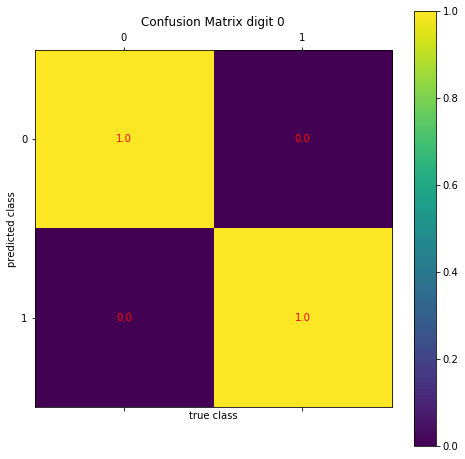

Accuracy:  1.0 
Precision:  1.0 
Recall:  1.0 


#######
digit = 1


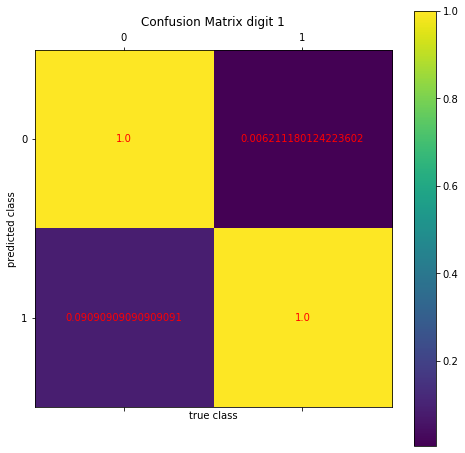

Accuracy:  0.9861111111111112 
Precision:  0.9428571428571428 
Recall:  0.9166666666666666 


#######
digit = 2


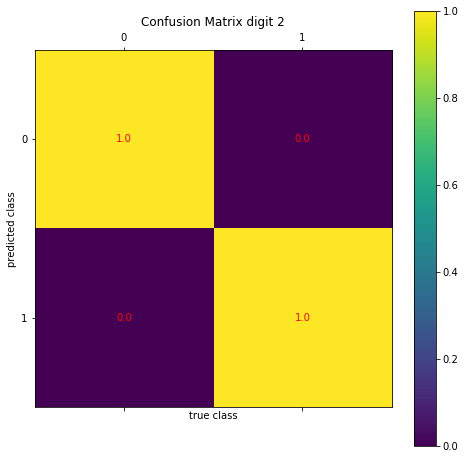

Accuracy:  1.0 
Precision:  1.0 
Recall:  1.0 


#######
digit = 3


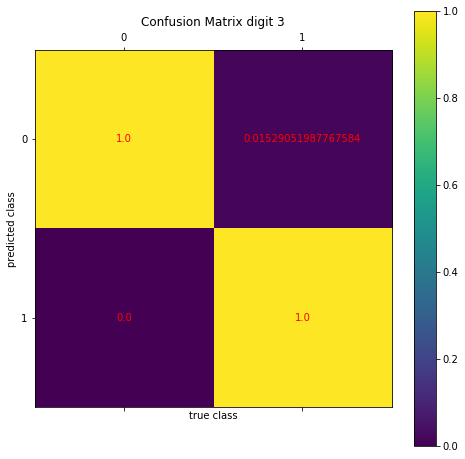

Accuracy:  0.9861111111111112 
Precision:  0.8484848484848485 
Recall:  1.0 


#######
digit = 4


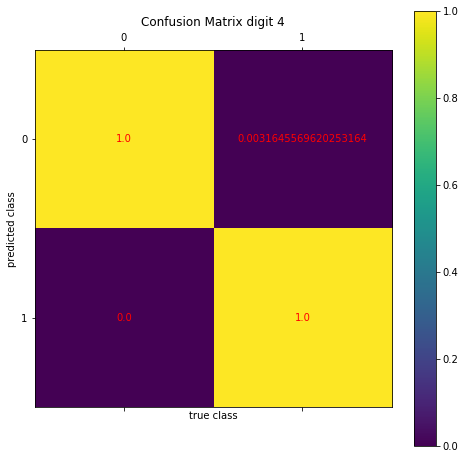

Accuracy:  0.9972222222222222 
Precision:  0.9772727272727273 
Recall:  1.0 


#######
digit = 5


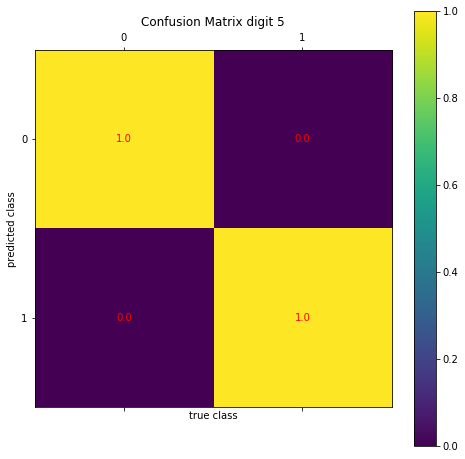

Accuracy:  1.0 
Precision:  1.0 
Recall:  1.0 


#######
digit = 6


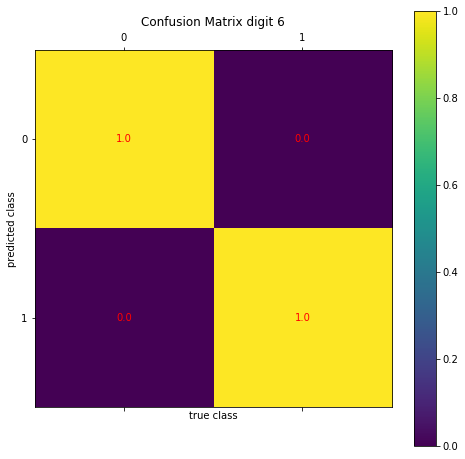

Accuracy:  1.0 
Precision:  1.0 
Recall:  1.0 


#######
digit = 7


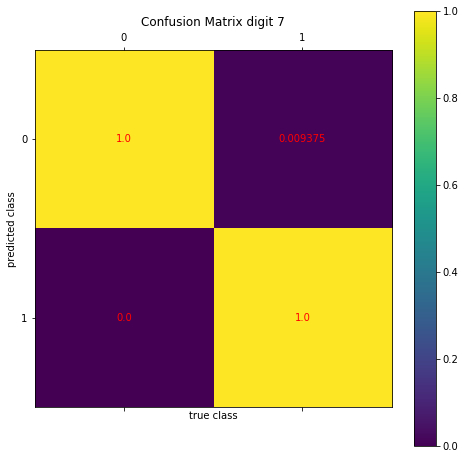

Accuracy:  0.9916666666666667 
Precision:  0.925 
Recall:  1.0 


#######
digit = 8


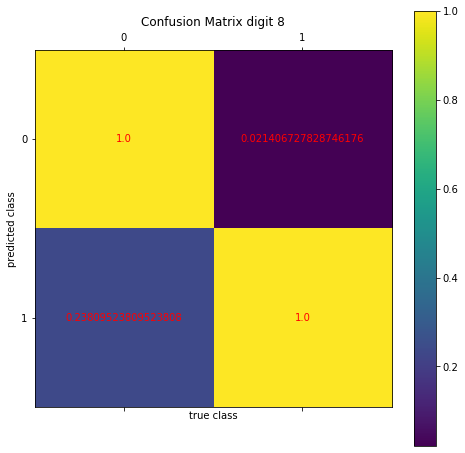

Accuracy:  0.9666666666666667 
Precision:  0.75 
Recall:  0.8076923076923077 


#######
digit = 9


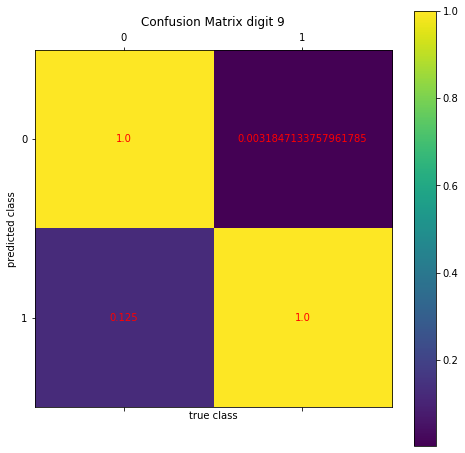

Accuracy:  0.9833333333333333 
Precision:  0.975609756097561 
Recall:  0.8888888888888888 




In [125]:
for tar in targets:
    print(f'#######\ndigit = {tar}')
    #tar = 0
    y_pred, h = lr.LogisticRegression_predict(X_test, thetas[tar])
    #print(y_pred)
    #print(y_test_t[tar])
    #print(y_pred)
    acc = lr.accuracy_score(y_pred,y_test_t[tar])
    precision = lr.precision_score(y_pred,y_test_t[tar])
    recall = lr.recall_score(y_pred,y_test_t[tar])
    

    mat = confusion_mat(y_pred, y_test_t[tar])

    mat = mat / np.max(np.abs(mat),axis=0) 

    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(f'Confusion Matrix digit {tar}')
    ax.set_xlabel('true class')
    ax.set_ylabel('predicted class')


    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, mat[i, j],
                           ha="center", va="center", color="r")
    cax = ax.matshow(mat)
    fig.colorbar(cax)
    plt.show()

#fig1 = plt.figure(figsize=(16, 6))

#plt.show()
#ax.set_title(f"relative Häufigkeitsverteilung feature {ind} je Helligkeitswert")
    print('Accuracy: ',acc,'\nPrecision: ',precision,'\nRecall: ', recall,'\n\n')


Zu sehen ist, dass die Klassifizierung in "Zahl" und  "andere Zahl" relativ gut funktioniert hat. Die Zahlen 0, 2, 5, 6 können perfekt validiert werden, was aber ggf auf eine Überapassung hindeutet.

Auffälig ist noch, das bei den Zahlen 8 und 9 über 12% der "anderen Zahlen" als 8 oder 9 Klassifiziert wurden.

### Lernkurven und andere Kennzahlen

Um zu sehen ob ein traniertes Modell überangepasst ist, wird eine Lernkurve erzeugt. Es werden n Modelle erzeugt welche mit einer steigenden Anzahl an Trainingsdatensätzen triniert wird und anschließend validiert wird.

Um Zeit zu sparen wird die Ausschließlich für die Zahl 9 getan. Es sollten aber alle Zahlen überprüft werden.

In [126]:
over = range(1,1400,20)
time_start = time.time()
thetas_lc = []
Js_lc = []
Js_te = []
counters_lc = []

prec_tr = []
rec_tr = []
rmse_tr = []
acc_tr = []
h_tr = []

print(f'learning digit {tar}...')

for d in over:
    X_train_lc = X_train[:d]
    y_train_lc = y_train_t[9][:d]
    
    

    theta, J, counter = lr.LogisticRegression_fit(X_train_lc, y_train_lc, eta_min_J, 3e-4)

    print(f'Calculating for {d} samples done... \n cost =',J,' diff:',J-Js_lc[-1] if len(Js_lc)>0 else False ,'\n')
    thetas_lc.append(theta)
    Js_lc.append(J)
    counters_lc.append(counter)

    y_pred_tr, h = lr.LogisticRegression_predict(X_train_lc, theta)

    # Kennzahlen training
    rmse_tr.append(root_means(y_train_lc,y_pred_tr))
    acc_tr.append(lr.accuracy_score(y_train_lc,y_pred_tr))
    prec_tr.append(lr.precision_score(y_train_lc,y_pred_tr))
    rec_tr.append(lr.recall_score(y_train_lc,y_pred_tr))
    h_tr.append(h)

    
    if d > 1200:
         if np.all(Js_lc[-3] <= J):
            print("Kosten bleibt gleich oder steigt")
            break

            
            
print(f'took {np.sum(counters_lc)} iterations in {time.time()-time_start} seconds ({np.sum(counters_lc)/(time.time()-time_start)} iter/sec)...\n\n')



learning digit 9...
Calculating for 1 samples done... 
 cost = 3.658066319463885e-07  diff: False 

Calculating for 21 samples done... 
 cost = 0.00040293524165193847  diff: 0.00040256943501999206 



/usr/local/etc/jupyter/uni/logistische_regression.py:291: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)


Calculating for 41 samples done... 
 cost = 0.0005296841958399075  diff: 0.00012674895418796908 

Calculating for 61 samples done... 
 cost = 0.0008336923507214209  diff: 0.00030400815488151336 

Calculating for 81 samples done... 
 cost = 0.0009438667153352504  diff: 0.00011017436461382946 

Calculating for 101 samples done... 
 cost = 0.001021841701690839  diff: 7.797498635558865e-05 

Calculating for 121 samples done... 
 cost = 0.0014379982119553316  diff: 0.00041615651026449254 

Calculating for 141 samples done... 
 cost = 0.0015778578049056202  diff: 0.00013985959295028869 

Calculating for 161 samples done... 
 cost = 0.0016202293001187245  diff: 4.237149521310428e-05 

Calculating for 181 samples done... 
 cost = 0.0017641084213171766  diff: 0.00014387912119845207 

Calculating for 201 samples done... 
 cost = 0.0020462429037112454  diff: 0.0002821344823940688 

Calculating for 221 samples done... 
 cost = 0.0021992987901768286  diff: 0.00015305588646558326 

Calculating for 2

In [127]:
# Berechnung Kennzahlen Testdata

#print(len(thetas_lc))


Js_le = []
rmse_te = []
acc_te = []
prec_te = []
rec_te = []
h_te = []

for theta in thetas_lc:
    
    y_pred_te, h_ = lr.LogisticRegression_predict(X_test, theta)
    
    J_te, Jgrad = lr.logistic_cost_function(X_test, y_test_t[9], theta)
    Js_le.append(J_te)
    rmse_te.append(root_means(y_test_t[9],y_pred_te))
    acc_te.append(lr.accuracy_score(y_test_t[9],y_pred_te))

    prec_te.append(lr.precision_score(y_test_t[9],y_pred_te))
    rec_te.append(lr.recall_score(y_test_t[9],y_pred_te))
    h_te.append(h_)

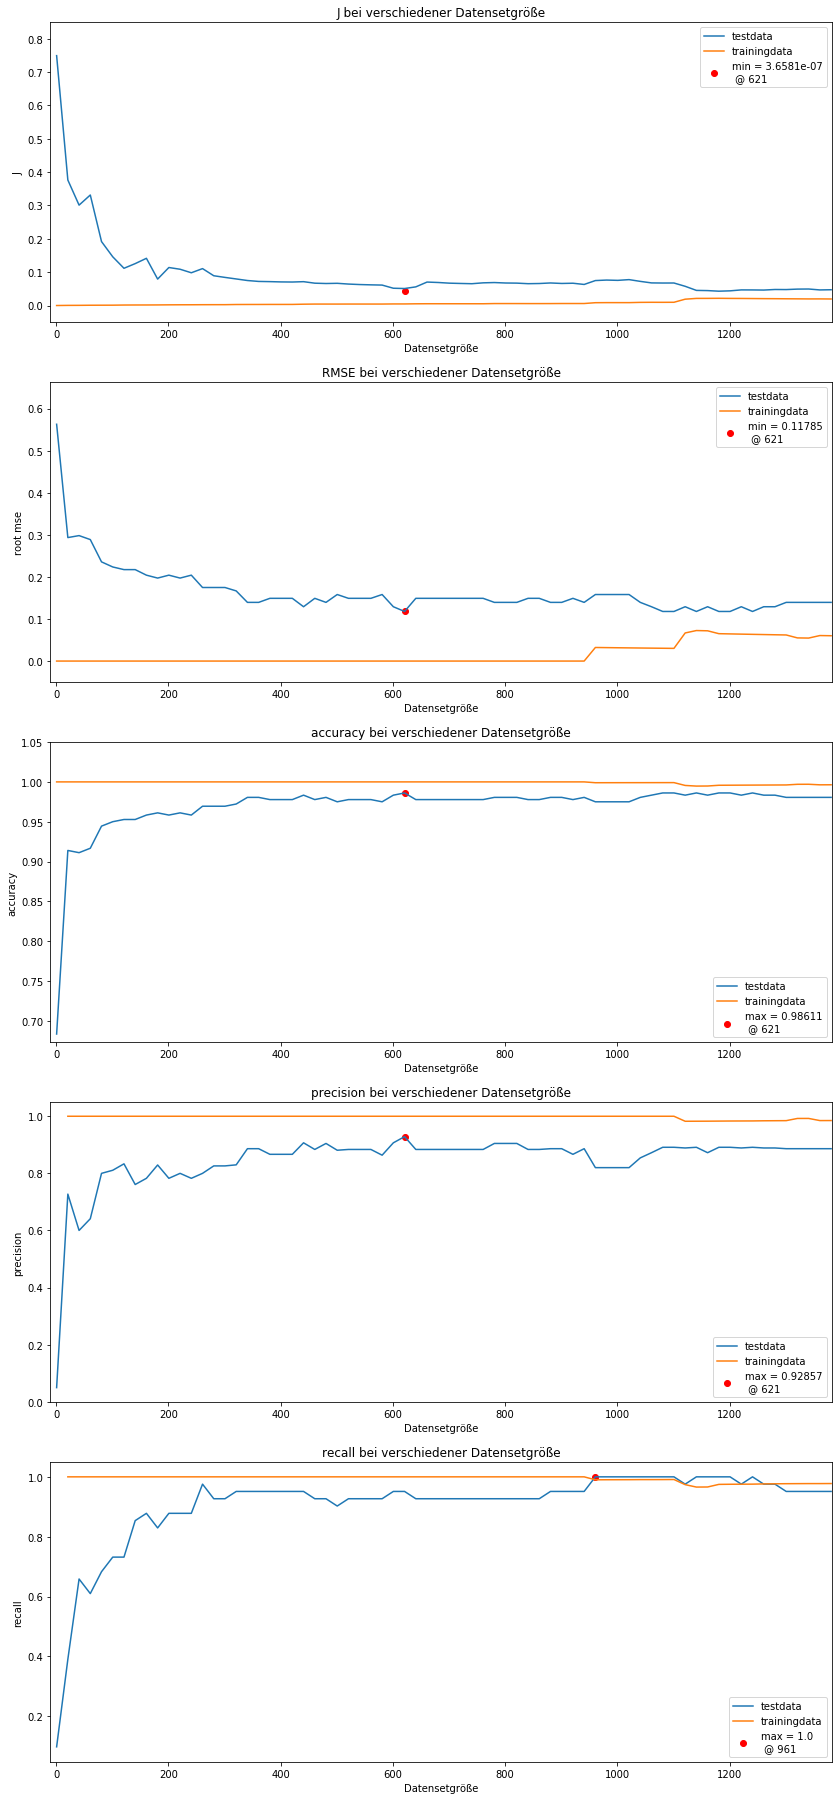

In [131]:
over = range(1,d+20,20)
overmin_J = over[np.argmin(Js_lc)]
overmin_te = over[np.argmin(rmse_te)]
overmin_tr = over[np.argmax(acc_te)]
overmin_prec = over[np.argmax(prec_te)]
overmin_rec = over[np.argmax(rec_te)]
text = "Datensetgröße"

fig = plt.figure(figsize=(14, 32))
gs = gridspec.GridSpec(5, 1)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[1])

ax.set_title(f'J bei verschiedener {text}')
ax.plot(over, Js_le, label='testdata')
ax.plot(over, Js_lc, label='trainingdata')
#ax.scatter(overmin_tr, np.min(Js_le), color='r', marker='o', label='min')
ax.scatter(overmin_te, np.min(Js_le), color='r', 
           marker='o', label=f'min = {np.min(Js_lc):.5}\n @ {overmin_te}')
ax.set_ylabel('J')
ax.set_xlabel(f'{text}')
ax.set_ylim(-0.05,max(Js_le)+0.1)
ax.set_xlim(-10,max(over)+1)
ax.legend()


ax5.set_title(f'RMSE bei verschiedener {text}')
ax5.plot(over, rmse_te, label='testdata')
ax5.plot(over, rmse_tr, label='trainingdata')
#ax.scatter(overmin_tr, np.min(np.sqrt(mse_train)), color='r', marker='o', label='min')
ax5.scatter(overmin_te, np.min(rmse_te), color='r', 
           marker='o', label=f'min = {np.min(rmse_te):.5}\n @ {overmin_te}')
ax5.set_ylabel('root mse')
ax5.set_xlabel(f'{text}')
ax5.set_ylim(-0.05,max(rmse_te)+0.1)
ax5.set_xlim(-10,max(over)+1)
ax5.legend()

ax2.set_title(f'accuracy bei verschiedener {text}')
ax2.plot(over, acc_te, label='testdata')
ax2.plot(over, acc_tr, label='trainingdata')
#ax2.scatter(overmin_tr, np.min(np.sqrt(mse_train)), color='r', marker='o')
ax2.scatter(overmin_tr, np.max(acc_te), color='r',
            marker='o', label=f'max = {np.max(acc_te):.5}\n @ {overmin_tr}')

ax2.set_ylabel('accuracy')
ax2.set_xlabel(f'{text}')
# ax2.set_xlim(110,160)
# ax2.set_ylim(2.75,3.7)
ax2.set_ylim(min(acc_te)-0.01,1.05)
ax2.set_xlim(-10,max(over)+1)
ax2.legend()

ax3.set_title(f'precision bei verschiedener {text}')
ax3.plot(over, prec_te, label='testdata')
ax3.plot(over, prec_tr, label='trainingdata')
#ax2.scatter(overmin_tr, np.min(np.sqrt(mse_train)), color='r', marker='o')
ax3.scatter(overmin_tr, np.max(prec_te), color='r',
            marker='o', label=f'max = {np.max(prec_te):.5}\n @ {overmin_prec}')
ax3.set_ylabel('precision')
ax3.set_xlabel(f'{text}')
# ax2.set_xlim(110,160)
# ax2.set_ylim(2.75,3.7)
ax3.set_ylim(min(prec_te)-0.05,1.05)
ax3.set_xlim(-10,max(over)+1)
ax3.legend()

ax4.set_title(f'recall bei verschiedener {text}')
ax4.plot(over, rec_te, label='testdata')
ax4.plot(over, rec_tr, label='trainingdata')
#ax2.scatter(overmin_tr, np.min(np.sqrt(mse_train)), color='r', marker='o')
ax4.scatter(overmin_rec, np.max(rec_te), color='r',
            marker='o', label=f'max = {np.max(rec_te):.5}\n @ {overmin_rec}')
ax4.set_ylabel('recall')
ax4.set_xlabel(f'{text}')
# ax2.set_xlim(110,160)
# ax2.set_ylim(2.75,3.7)
ax4.set_ylim(min(rec_te)-0.05,1.05)
ax4.set_xlim(-10,max(over)+1)
ax4.legend()

#plt.savefig(f'learncurve_{text}.png')
plt.show()


Die oben dargestellten Lernkurven zeigen verschiedene Kennzahlen über verschiedene Trainingssetgrößen an. Die orangene Linie zeigt die Kennzahlen nach der Validierung mit den Trainingsdaten während des Trainings und die blaue Linie zeigt die Kennzahlen nach der Validierung mit den unbekannten Testdaten.
Zu sehen ist, dass das Modell bis zu einem gewissen Punkt an Überapassung leidet. Grob abgelesen, benötigt das Modell min. 1000 Trainingsdatensätze, um die Zusammenhänge gut genug zu abstrahieren, sodass das Modell bei neuen unbekannten Datensätzen nicht kläglich versagt.
Somit wäre auch der Ansatz die Datensetzt auf Klassenbalance hin anzupassen nicht ohne weiteres möglich.


### Regularisierung
Eine Regularisierung dient dazu um bei einem Modell zu verhindern, dass es sich an die Trainingsdaten überanpasst. Von daher ist eine Regularisierung generell sehr Ratsam.
In unserer Implemntierung des Gradientenverfahrens wurde eine Toleranz eingeführt, welche den Algorithmus abbricht, sobalt diese unterschritten wurde, womit die entstandenen Modelle in gewisser Weise reguliert sind. Traditionell wird die Regularisierung aber mit einem Faktor bei der Kostenfunktion realisiert, was hier nicht gemacht wurde.